In [4]:
import datetime
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datlib.FRED import *
from datlib.plots import *
import pandas_datareader.data as web

%matplotlib inline

# Import Statsmodels

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [5]:
#FRED.py
#. . . 
def bil_to_mil(series):
    return series* 10**3
# . . .
#fedProject.py
# . . .
data_codes  = {# Assets
               "Balance Sheet: Total Assets ($ Mil)": "WALCL",
               "Balance Sheet Securities, Prem-Disc, Repos, and Loans ($ Mil)": "WSRLL",
               "Balance Sheet: Securities Held Outright ($ Mil)": "WSHOSHO",
               ### breakdown of securities holdings ###
               "Balance Sheet: U.S. Treasuries Held Outright ($ Mil)":"WSHOTSL",
               "Balance Sheet: Federal Agency Debt Securities ($ Mil)" : "WSHOFADSL",
               "Balance Sheet: Mortgage-Backed Securities ($ Mil)": "WSHOMCB",
               # other forms of lending
               "Balance Sheet: Repos ($ Mil)": "WORAL",
               "Balance Sheet: Central Bank Liquidity Swaps ($ Mil)" : "SWPT",
               "Balance Sheet: Direct Lending ($ Mil)" : "WLCFLL",
               # unamortized value of securities held (due to changes in interest rates)
               "Balance Sheet: Unamortized Security Premiums ($ Mil)": "WUPSHO",
               # Liabilities
               "Balance Sheet: Total Liabilities ($ Mil)" : "WLTLECL",
               "Balance Sheet: Federal Reserve Notes Outstanding ($ Mil)" : "WLFN",
               "Balance Sheet: Reverse Repos ($ Mil)": "WLRRAL",
               ### Major share of deposits 
               "Balance Sheet: Deposits from Dep. Institutions ($ Mil)":"WLODLL",
               "Balance Sheet: U.S. Treasury General Account ($ Mil)": "WDTGAL",
               "Balance Sheet: Other Deposits ($ Mil)": "WOTHLB",
               "Balance Sheet: All Deposits ($ Mil)": "WLDLCL",
               # Capital
               "Balance Sheet: Total Capital": "WCTCL",
               # Interest Rates
               "Unemployment Rate": "UNRATE",
               "Nominal GDP ($ Bil)":"GDP",
               "Real GDP ($ Bil)":"GDPC1",
               "GDP Deflator":"GDPDEF",
               "CPI":"CPIAUCSL",
               "Core PCE":"PCEPILFE",
               "Private Investment":"GPDI",
               "Base: Total ($ Mil)": "BOGMBASE",
               "Base: Currency in Circulation ($ Bil)": "WCURCIR",
               "1 Month Treasury Rate (%)": "DGS1MO",
               "3 Month Treasury Rate (%)": "DGS3MO",               
               "1 Year Treasury Rate (%)": "DGS1",
               "2 Year Treasury Rate (%)": "DGS2",
               "10 Year Treasury Rate (%)": "DGS10",
               "30 Year Treasury Rate (%)": "DGS30",               
               "Effective Federal Funds Rate (%)": "DFF",
               "Federal Funds Target Rate (Pre-crisis)":"DFEDTAR",
               "Federal Funds Upper Target":"DFEDTARU",
               "Federal Funds Lower Target":"DFEDTARL",
               "Interest on Reserves (%)": "IOER",
               "VIX": "VIXCLS",
                "5 Year Forward Rate": "T5YIFR"
               }

inflation_target = 2

unemployment_target = 4
# Select start and end dates
start = datetime.datetime(2000, 1, 1)
end = datetime.datetime.today()

## year variable automatically adjusts the numper of periods  
#   per year in light of data frequency
annual_div = {"Q":4,
             "W":52,
             "M":12}
### choose frequency
freq = "M"
### set periods per year
year = annual_div[freq]


In [6]:
#data cleaning, importing

d_parser = lambda x: pd.datetime.strptime(x, '%m/%d/%Y')
df = pd.read_csv('M4.csv', parse_dates=['Date'], date_parser=d_parser)

C:\Users\HP\AppData\Local\Temp/ipykernel_1052/234952859.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  d_parser = lambda x: pd.datetime.strptime(x, '%m/%d/%Y')


In [8]:
df

Date  Log M4 including Treasuries  Log Total Assets  \
0   2010-01-31                        7.069            14.629   
1   2010-02-28                        7.063            14.634   
2   2010-03-31                        7.054            14.648   
3   2010-04-30                        7.058            14.661   
4   2010-05-31                        7.061            14.664   
..         ...                          ...               ...   
115 2019-08-31                        7.397            15.143   
116 2019-09-30                        7.404            15.153   
117 2019-10-31                        7.413            15.194   
118 2019-11-30                        7.420            15.212   
119 2019-12-31                        7.424            15.230   

     Effective Federal Funds Rate (%)  Loss Function  \
0                               0.110        -33.736   
1                               0.126        -33.731   
2                               0.165        -34.860   
3                               0.198        -34.969   
4                               0.201        -31.492   
..                                ...            ...   
115                             2.126          0.068   
116                             2.043          0.167   
117                             1.830          0.080   
118                             1.553         -0.027   
119                             1.551          0.029   

     Log Currency in Circulation ($ Bil)  
0                                   6.83  
1                                   6.83  
2                                   6.84  
3                                   6.84  
4                                   6.84  
..                                   ...  
115                                 7.47  
116                                 7.47  
117                                 7.48  
118                                 7.49  
119                                 7.49  

[120 rows x 6 columns]

In [9]:
df['Date_at_year_month'] = df['Date'].dt.strftime('%Y-%m')

In [10]:
df.head()

Date  Log M4 including Treasuries  Log Total Assets  \
0 2010-01-31                        7.069            14.629   
1 2010-02-28                        7.063            14.634   
2 2010-03-31                        7.054            14.648   
3 2010-04-30                        7.058            14.661   
4 2010-05-31                        7.061            14.664   

   Effective Federal Funds Rate (%)  Loss Function  \
0                             0.110        -33.736   
1                             0.126        -33.731   
2                             0.165        -34.860   
3                             0.198        -34.969   
4                             0.201        -31.492   

   Log Currency in Circulation ($ Bil) Date_at_year_month  
0                                 6.83            2010-01  
1                                 6.83            2010-02  
2                                 6.84            2010-03  
3                                 6.84            2010-04  
4                                 6.84            2010-05

In [14]:
column_names = {'Date_at_year_month':'DATE',
                'Log Log M4 including Treasuries':'M4',
                'Log Total Assets': 'TA',
                'Log Currency in Circulation ($ Bil)':'CC',
                'Effective Federal Funds Rate (%)':'FFR', 
                'Loss Function':'LF'}

# rename columns
df = df.rename(columns = column_names)

df

Log M4 including Treasuries      TA    FFR      LF    CC
DATE                                                             
2010-01                        7.069  14.629  0.110 -33.736  6.83
2010-02                        7.063  14.634  0.126 -33.731  6.83
2010-03                        7.054  14.648  0.165 -34.860  6.84
2010-04                        7.058  14.661  0.198 -34.969  6.84
2010-05                        7.061  14.664  0.201 -31.492  6.84
...                              ...     ...    ...     ...   ...
2019-08                        7.397  15.143  2.126   0.068  7.47
2019-09                        7.404  15.153  2.043   0.167  7.47
2019-10                        7.413  15.194  1.830   0.080  7.48
2019-11                        7.420  15.212  1.553  -0.027  7.49
2019-12                        7.424  15.230  1.551   0.029  7.49

[120 rows x 5 columns]

In [12]:
df = df.set_index('DATE')
df

Date  Log M4 including Treasuries      TA    FFR      LF    CC
DATE                                                                        
2010-01 2010-01-31                        7.069  14.629  0.110 -33.736  6.83
2010-02 2010-02-28                        7.063  14.634  0.126 -33.731  6.83
2010-03 2010-03-31                        7.054  14.648  0.165 -34.860  6.84
2010-04 2010-04-30                        7.058  14.661  0.198 -34.969  6.84
2010-05 2010-05-31                        7.061  14.664  0.201 -31.492  6.84
...            ...                          ...     ...    ...     ...   ...
2019-08 2019-08-31                        7.397  15.143  2.126   0.068  7.47
2019-09 2019-09-30                        7.404  15.153  2.043   0.167  7.47
2019-10 2019-10-31                        7.413  15.194  1.830   0.080  7.48
2019-11 2019-11-30                        7.420  15.212  1.553  -0.027  7.49
2019-12 2019-12-31                        7.424  15.230  1.551   0.029  7.49

[120 rows x 6 columns]

In [13]:
df = df.drop(['Date'], axis = 1)
df

Log M4 including Treasuries      TA    FFR      LF    CC
DATE                                                             
2010-01                        7.069  14.629  0.110 -33.736  6.83
2010-02                        7.063  14.634  0.126 -33.731  6.83
2010-03                        7.054  14.648  0.165 -34.860  6.84
2010-04                        7.058  14.661  0.198 -34.969  6.84
2010-05                        7.061  14.664  0.201 -31.492  6.84
...                              ...     ...    ...     ...   ...
2019-08                        7.397  15.143  2.126   0.068  7.47
2019-09                        7.404  15.153  2.043   0.167  7.47
2019-10                        7.413  15.194  1.830   0.080  7.48
2019-11                        7.420  15.212  1.553  -0.027  7.49
2019-12                        7.424  15.230  1.551   0.029  7.49

[120 rows x 5 columns]

In [15]:
data = df
data

Log M4 including Treasuries      TA    FFR      LF    CC
DATE                                                             
2010-01                        7.069  14.629  0.110 -33.736  6.83
2010-02                        7.063  14.634  0.126 -33.731  6.83
2010-03                        7.054  14.648  0.165 -34.860  6.84
2010-04                        7.058  14.661  0.198 -34.969  6.84
2010-05                        7.061  14.664  0.201 -31.492  6.84
...                              ...     ...    ...     ...   ...
2019-08                        7.397  15.143  2.126   0.068  7.47
2019-09                        7.404  15.153  2.043   0.167  7.47
2019-10                        7.413  15.194  1.830   0.080  7.48
2019-11                        7.420  15.212  1.553  -0.027  7.49
2019-12                        7.424  15.230  1.551   0.029  7.49

[120 rows x 5 columns]

In [16]:
data.isnull().sum()

Log M4 including Treasuries    0
TA                             0
FFR                            0
LF                             0
CC                             0
dtype: int64

In [17]:
## 1st diff
data_diff = data.diff().dropna()
data_diff

Log M4 including Treasuries     TA    FFR     LF    CC
DATE                                                           
2010-02                       -0.006  0.005  0.016  0.005  0.00
2010-03                       -0.009  0.014  0.039 -1.129  0.01
2010-04                        0.004  0.013  0.033 -0.109  0.00
2010-05                        0.003  0.003  0.003  3.477  0.00
2010-06                       -0.012  0.001 -0.024  2.135  0.01
...                              ...    ...    ...    ...   ...
2019-08                        0.007 -0.009 -0.277  0.049  0.00
2019-09                        0.007  0.010 -0.083  0.099  0.00
2019-10                        0.009  0.041 -0.213 -0.087  0.01
2019-11                        0.007  0.018 -0.277 -0.107  0.01
2019-12                        0.004  0.018 -0.002  0.056  0.00

[119 rows x 5 columns]

In [18]:
##2nd diff
data_new = data_diff.diff().dropna()
data_new

Log M4 including Treasuries            TA    FFR     LF            CC
DATE                                                                          
2010-03                -3.000000e-03  9.000000e-03  0.023 -1.134  1.000000e-02
2010-04                 1.300000e-02 -1.000000e-03 -0.006  1.020 -1.000000e-02
2010-05                -1.000000e-03 -1.000000e-02 -0.030  3.586  0.000000e+00
2010-06                -1.500000e-02 -2.000000e-03 -0.027 -1.342  1.000000e-02
2010-07                 2.500000e-02 -4.000000e-03  0.030 -2.219 -1.000000e-02
...                              ...           ...    ...    ...           ...
2019-08                 3.000000e-03  1.000000e-03 -0.302  0.110 -1.000000e-02
2019-09                -8.881784e-16  1.900000e-02  0.194  0.050  0.000000e+00
2019-10                 2.000000e-03  3.100000e-02 -0.130 -0.186  1.000000e-02
2019-11                -2.000000e-03 -2.300000e-02 -0.064 -0.020 -8.881784e-16
2019-12                -3.000000e-03  1.776357e-15  0.275  0.163 -1.000000e-02

[118 rows x 5 columns]

In [19]:
#ADF test

X = data_new["Log M4 including Treasuries"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
    
X = data_new["FFR"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
    
X = data_new["TA"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
    
X = data_new["CC"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
    
X = data_new["LF"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")

ADF Statistic: -7.182450
p-value: 0.000000
Critical Values:
	1%: -3.492
	5%: -2.888
	10%: -2.581
Reject Ho - Time Series is Stationary
ADF Statistic: -4.042269
p-value: 0.001205
Critical Values:
	1%: -3.492
	5%: -2.889
	10%: -2.581
Reject Ho - Time Series is Stationary
ADF Statistic: -12.362437
p-value: 0.000000
Critical Values:
	1%: -3.488
	5%: -2.887
	10%: -2.580
Reject Ho - Time Series is Stationary
ADF Statistic: -6.497273
p-value: 0.000000
Critical Values:
	1%: -3.494
	5%: -2.889
	10%: -2.582
Reject Ho - Time Series is Stationary
ADF Statistic: -8.209830
p-value: 0.000000
Critical Values:
	1%: -3.492
	5%: -2.889
	10%: -2.581
Reject Ho - Time Series is Stationary


In [20]:
## Partial Correlation

import statsmodels.api as sm

residuals = {}
for y_var in df.keys():
    X_vars = list(df.keys())
    X_vars.remove(y_var)
    X = df[X_vars]
    # Initial estimate should include constant
    #   This won't be the case we regress the errors
    X["Constant"] = 1
    # pass y_var as list for consistent structure
    y = df[[y_var]]
    model = sm.OLS(y, X)
    results = model.fit()
    residuals[y_var] = results.resid
residuals = pd.DataFrame(residuals)
residuals

Log M4 including Treasuries        TA       FFR        LF        CC
DATE                                                                        
2010-01                     0.020187  0.060959  0.023796  0.467717 -0.019013
2010-02                     0.014492  0.059137  0.032273 -0.073244 -0.013337
2010-03                    -0.006222  0.060957 -0.099173 -3.046983  0.011172
2010-04                    -0.001962  0.084488 -0.037391 -2.792894  0.006067
2010-05                     0.015104  0.055904  0.204932  0.947322 -0.017900
...                              ...       ...       ...       ...       ...
2019-08                     0.005328 -0.072814 -0.124484  0.843660 -0.001982
2019-09                     0.012726 -0.063141 -0.162250  1.306148 -0.008723
2019-10                     0.014053 -0.047673 -0.375993  0.201656 -0.005414
2019-11                     0.012040 -0.065007 -0.703870 -1.112143  0.002927
2019-12                     0.016993 -0.042108 -0.657037 -0.816942 -0.002666

[120 rows x 5 columns]

In [21]:
residuals.corr()[residuals.corr().abs() < 1].mul(-1).fillna(1).round(2)

Log M4 including Treasuries    TA   FFR    LF  \
Log M4 including Treasuries                         1.00 -0.24 -0.12 -0.61   
TA                                                 -0.24  1.00 -0.46  0.27   
FFR                                                -0.12 -0.46  1.00 -0.41   
LF                                                 -0.61  0.27 -0.41  1.00   
CC                                                  0.92  0.30  0.47  0.78   

                               CC  
Log M4 including Treasuries  0.92  
TA                           0.30  
FFR                          0.47  
LF                           0.78  
CC                           1.00

In [22]:
# !pip install pingouin
import pingouin
df.pcorr().round(2)

Log M4 including Treasuries    TA   FFR    LF  \
Log M4 including Treasuries                         1.00 -0.24 -0.12 -0.61   
TA                                                 -0.24  1.00 -0.46  0.27   
FFR                                                -0.12 -0.46  1.00 -0.41   
LF                                                 -0.61  0.27 -0.41  1.00   
CC                                                  0.92  0.30  0.47  0.78   

                               CC  
Log M4 including Treasuries  0.92  
TA                           0.30  
FFR                          0.47  
LF                           0.78  
CC                           1.00

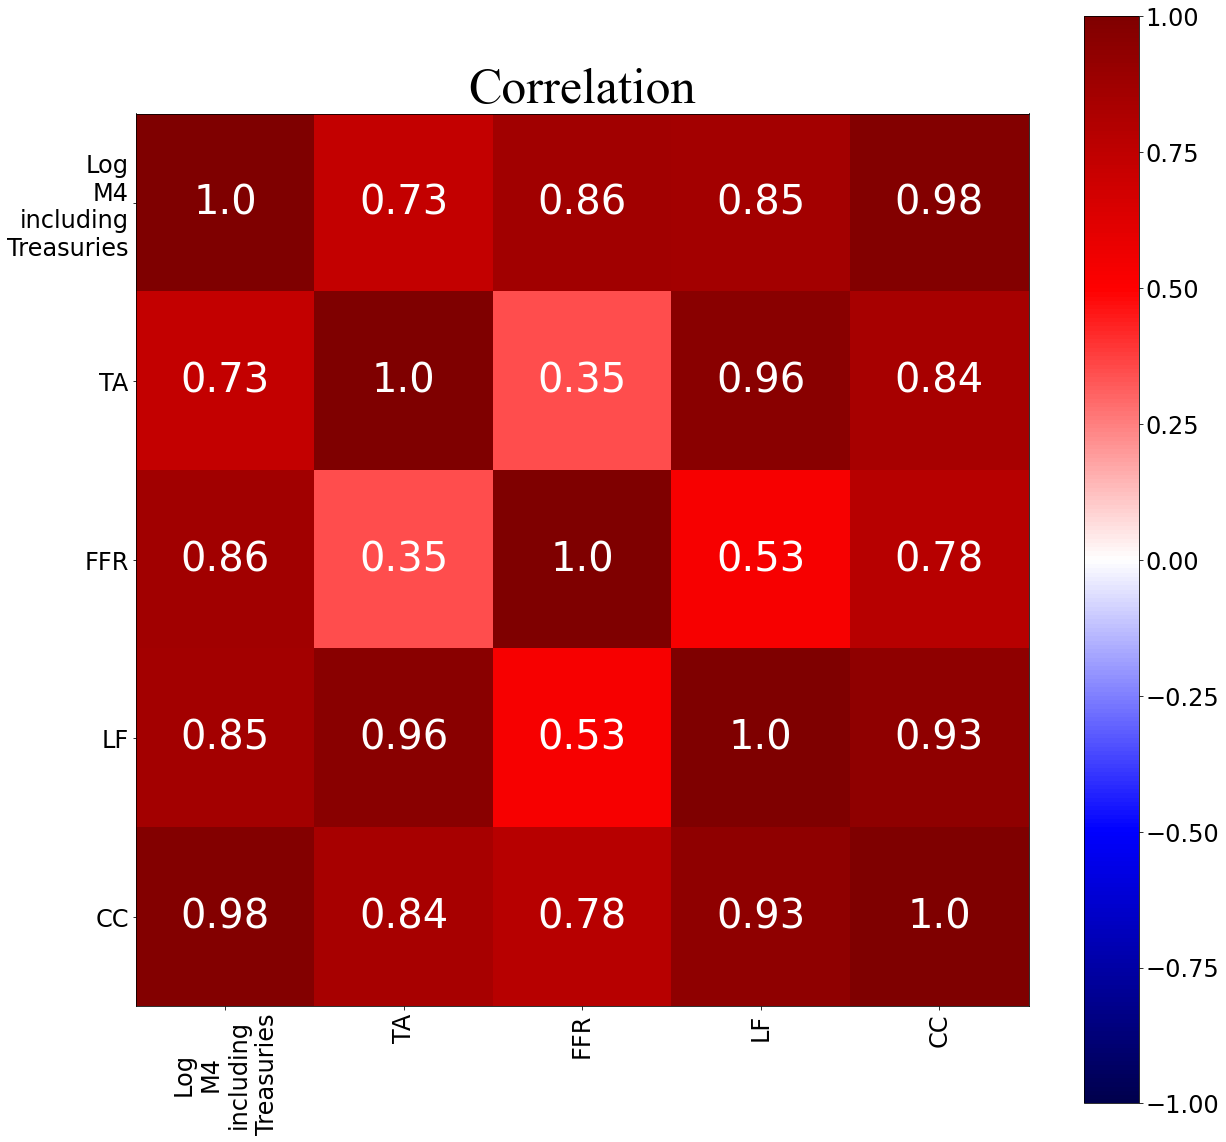

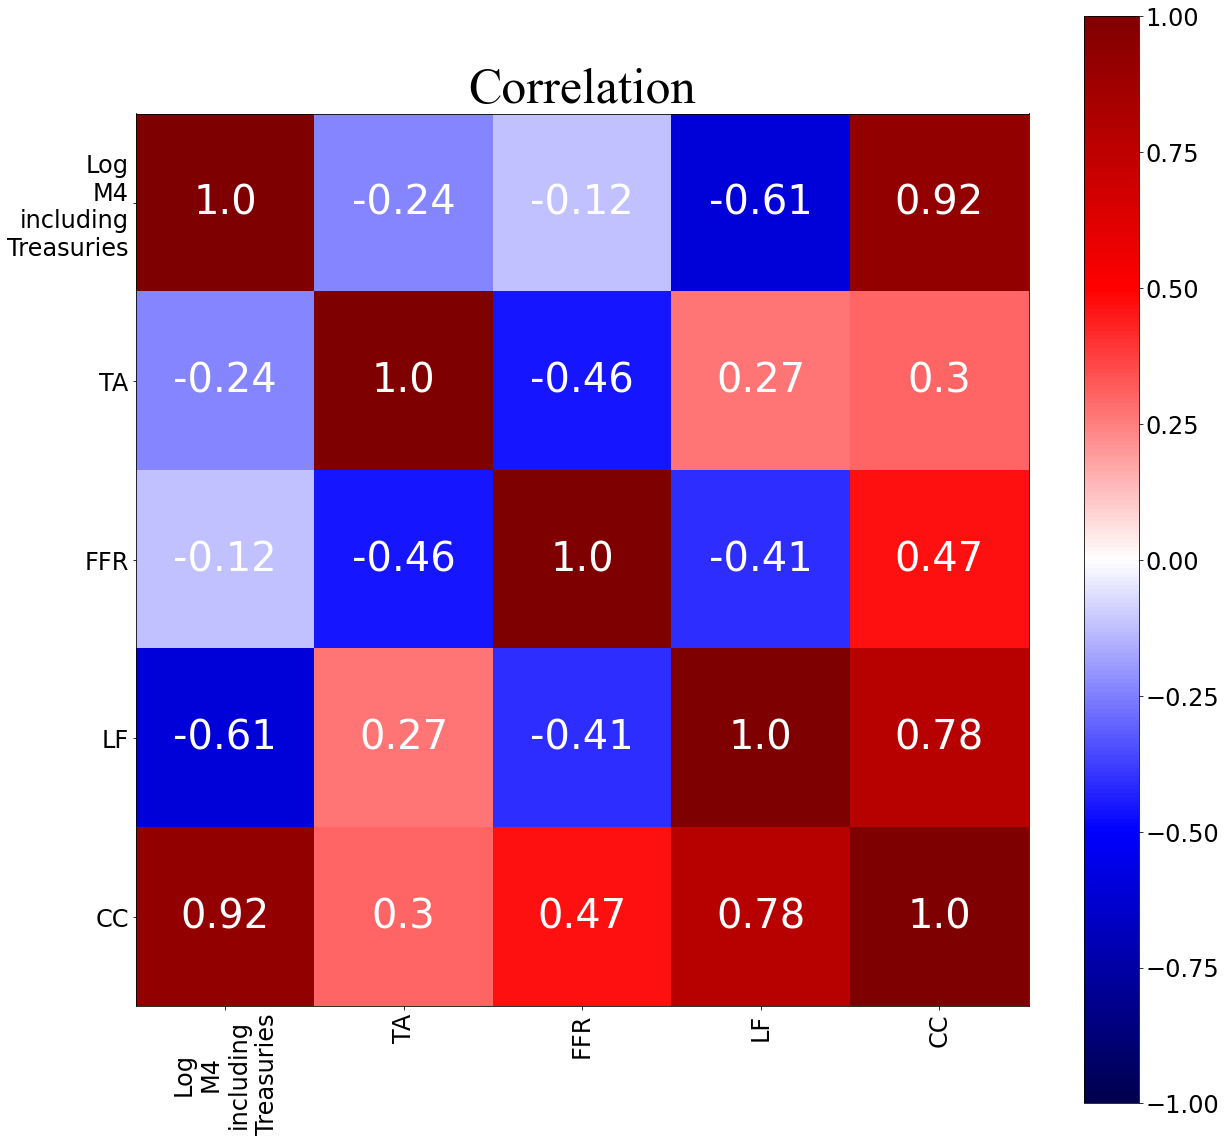

In [23]:
from datlib.plots import *
corr_matrix_heatmap(df.corr(), 
                    save_fig = False, 
                    pp = None)
corr_matrix_heatmap(df.pcorr(), save_fig = False, pp = None)

In [24]:
residuals

Log M4 including Treasuries        TA       FFR        LF        CC
DATE                                                                        
2010-01                     0.020187  0.060959  0.023796  0.467717 -0.019013
2010-02                     0.014492  0.059137  0.032273 -0.073244 -0.013337
2010-03                    -0.006222  0.060957 -0.099173 -3.046983  0.011172
2010-04                    -0.001962  0.084488 -0.037391 -2.792894  0.006067
2010-05                     0.015104  0.055904  0.204932  0.947322 -0.017900
...                              ...       ...       ...       ...       ...
2019-08                     0.005328 -0.072814 -0.124484  0.843660 -0.001982
2019-09                     0.012726 -0.063141 -0.162250  1.306148 -0.008723
2019-10                     0.014053 -0.047673 -0.375993  0.201656 -0.005414
2019-11                     0.012040 -0.065007 -0.703870 -1.112143  0.002927
2019-12                     0.016993 -0.042108 -0.657037 -0.816942 -0.002666

[120 rows x 5 columns]

In [25]:
pcorr_pvalues = {}
for y, Y in residuals.items():
    pcorr_pvalues[y] = {}
    for x, X in residuals.items():
        if x != y:
            pcorr_pvalues[y][x] = sm.OLS(Y,X).fit().pvalues[x]
        
        else:
            pcorr_pvalues[y][x] = np.NaN
pd.DataFrame(pcorr_pvalues).round(2)

Log M4 including Treasuries    TA   FFR   LF   CC
Log M4 including Treasuries                          NaN  0.01  0.19  0.0  0.0
TA                                                  0.01   NaN  0.00  0.0  0.0
FFR                                                 0.19  0.00   NaN  0.0  0.0
LF                                                  0.00  0.00  0.00  NaN  0.0
CC                                                  0.00  0.00  0.00  0.0  NaN

In [26]:
##DAG

import pingouin
from pgmpy.estimators import PC
import matplotlib.pyplot as plt
from matplotlib.patches import ArrowStyle
from networkx.drawing.nx_agraph import graphviz_layout
import warnings
warnings.filterwarnings("ignore")
from matplotlib.backends.backend_pdf import PdfPages
import networkx as nx

In [27]:
## Estimating a Directed Acyclic Graph
p_val = .01
from pgmpy.estimators import PC
c = PC(df)
max_cond_vars = len(df.keys())-2


model = c.estimate(return_type = "dag",variant= "parallel",#"orig", "stable"
                   significance_level = p_val, 
                   max_cond_vars = max_cond_vars, ci_test = "pearsonr")
edges = model.edges()

  0%|          | 0/3 [00:00<?, ?it/s]

OutEdgeView([('TA', 'FFR'), ('TA', 'Log M4 including Treasuries'), ('LF', 'FFR'), ('LF', 'CC'), ('Log M4 including Treasuries', 'FFR'), ('CC', 'FFR')])

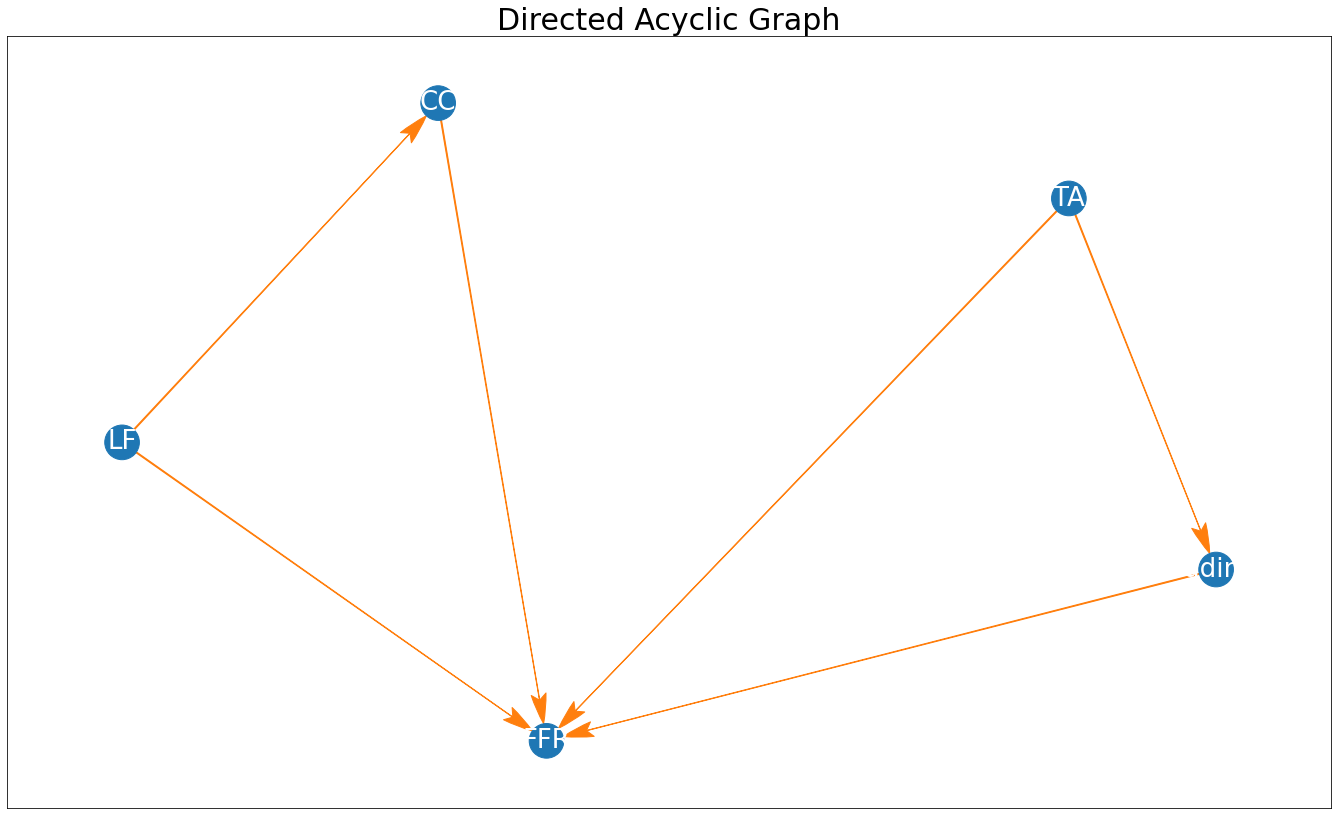

In [28]:
from matplotlib.patches import ArrowStyle

def graph_DAG(edges, df, title = ""):
    graph = nx.DiGraph()
    graph.add_edges_from(edges)
    color_map = ["C0" for g in graph]

    fig, ax = plt.subplots(figsize = (20,12))
    graph.nodes()
    plt.tight_layout()
    pos = nx.spring_layout(graph)#, k = 5/(len(sig_corr.keys())**.5))

    plt.title(title, fontsize = 30)
    nx.draw_networkx(graph, pos, node_color=color_map, node_size = 1200,
                     with_labels=True,  arrows=True,
                     font_color = "white",
                     font_size = 26, alpha = 1,
                     width = 1, edge_color = "C1",
                     arrowstyle=ArrowStyle("Fancy, head_length=3, head_width=1.5, tail_width=.1"), ax = ax)

graph_DAG(edges, df, title = "Directed Acyclic Graph")
edges

keep control: Log M4 including Treasuries
keep control: LF
keep control: CC
('TA', 'FFR') ['Log M4 including Treasuries', 'LF', 'CC']
('TA', 'Log M4 including Treasuries') []
keep control: Log M4 including Treasuries
keep control: CC
keep control: TA
('LF', 'FFR') ['Log M4 including Treasuries', 'CC', 'TA']
('LF', 'CC') []
keep control: LF
keep control: CC
keep control: TA
('Log M4 including Treasuries', 'FFR') ['LF', 'CC', 'TA']
keep control: Log M4 including Treasuries
keep control: LF
keep control: TA
('CC', 'FFR') ['Log M4 including Treasuries', 'LF', 'TA']


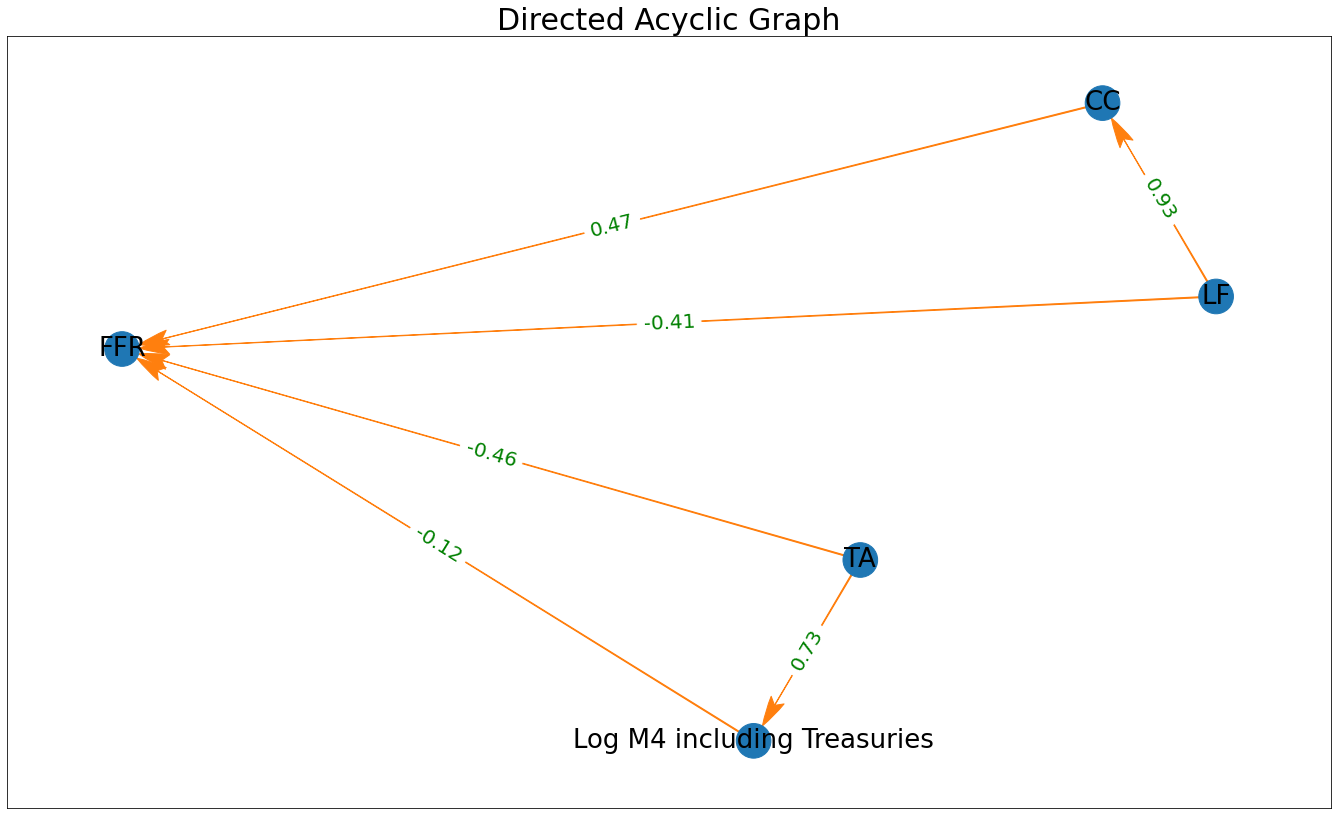

In [29]:
## D-separation

def graph_DAG(edges, df, title = ""):
    graph = nx.DiGraph()
    edge_labels = {}
    ############ Add ############
    for edge in edges:
        controls = [key for key in df.keys() if key not in edge]
        controls = list(set(controls))
        keep_controls = []
        for control in controls:
            control_edges = [ctrl_edge for ctrl_edge in edges if control == ctrl_edge[0] ]
            if (control, edge[1]) in control_edges:
                print("keep control:", control)
                keep_controls.append(control)                
        print(edge, keep_controls)
        pcorr = df[[edge[0], edge[1]]+keep_controls].pcorr()
#         corr_matrix_heatmap(pcorr, save_fig = False, pp = None, title = "Partial Correlation")
        edge_labels[edge] = str(round(pcorr[edge[0]].loc[edge[1]],2))
    graph.add_edges_from(edges)
    color_map = ["C0" for g in graph]

    fig, ax = plt.subplots(figsize = (20,12))
    graph.nodes()
    plt.tight_layout()
    pos = nx.spring_layout(graph)#, k = 5/(len(sig_corr.keys())**.5))

    plt.title(title, fontsize = 30)
    nx.draw_networkx(graph, pos, node_color=color_map, node_size = 1200,
                     with_labels=True,  arrows=True,
                     # turn text black for larger variable names in homework
                     font_color = "k",
                     font_size = 26, alpha = 1,
                     width = 1, edge_color = "C1",
                     arrowstyle=ArrowStyle("Fancy, head_length=3, head_width=1.5, tail_width=.1"), ax = ax)
    ############ Add ############
    nx.draw_networkx_edge_labels(graph,pos,
                                edge_labels=edge_labels,
                                font_color='green',
                                font_size=20)

graph_DAG(edges, df, title = "Directed Acyclic Graph")

In [30]:
data = df

In [31]:
def firstLetterWord(str, num_chars = 3):
 
    result = ""
 
    # Traverse the string.
    v = True
    for i in range(len(str)):
         
        # If it is space, set v as true.
        if (str[i] == ' '):
            v = True
 
        # Else check if v is true or not.
        # If true, copy character in output
        # string and set v as false.
        elif (str[i] != ' ' and v == True):
            result += (str[i:i+num_chars])
            v = False
 
    return result

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

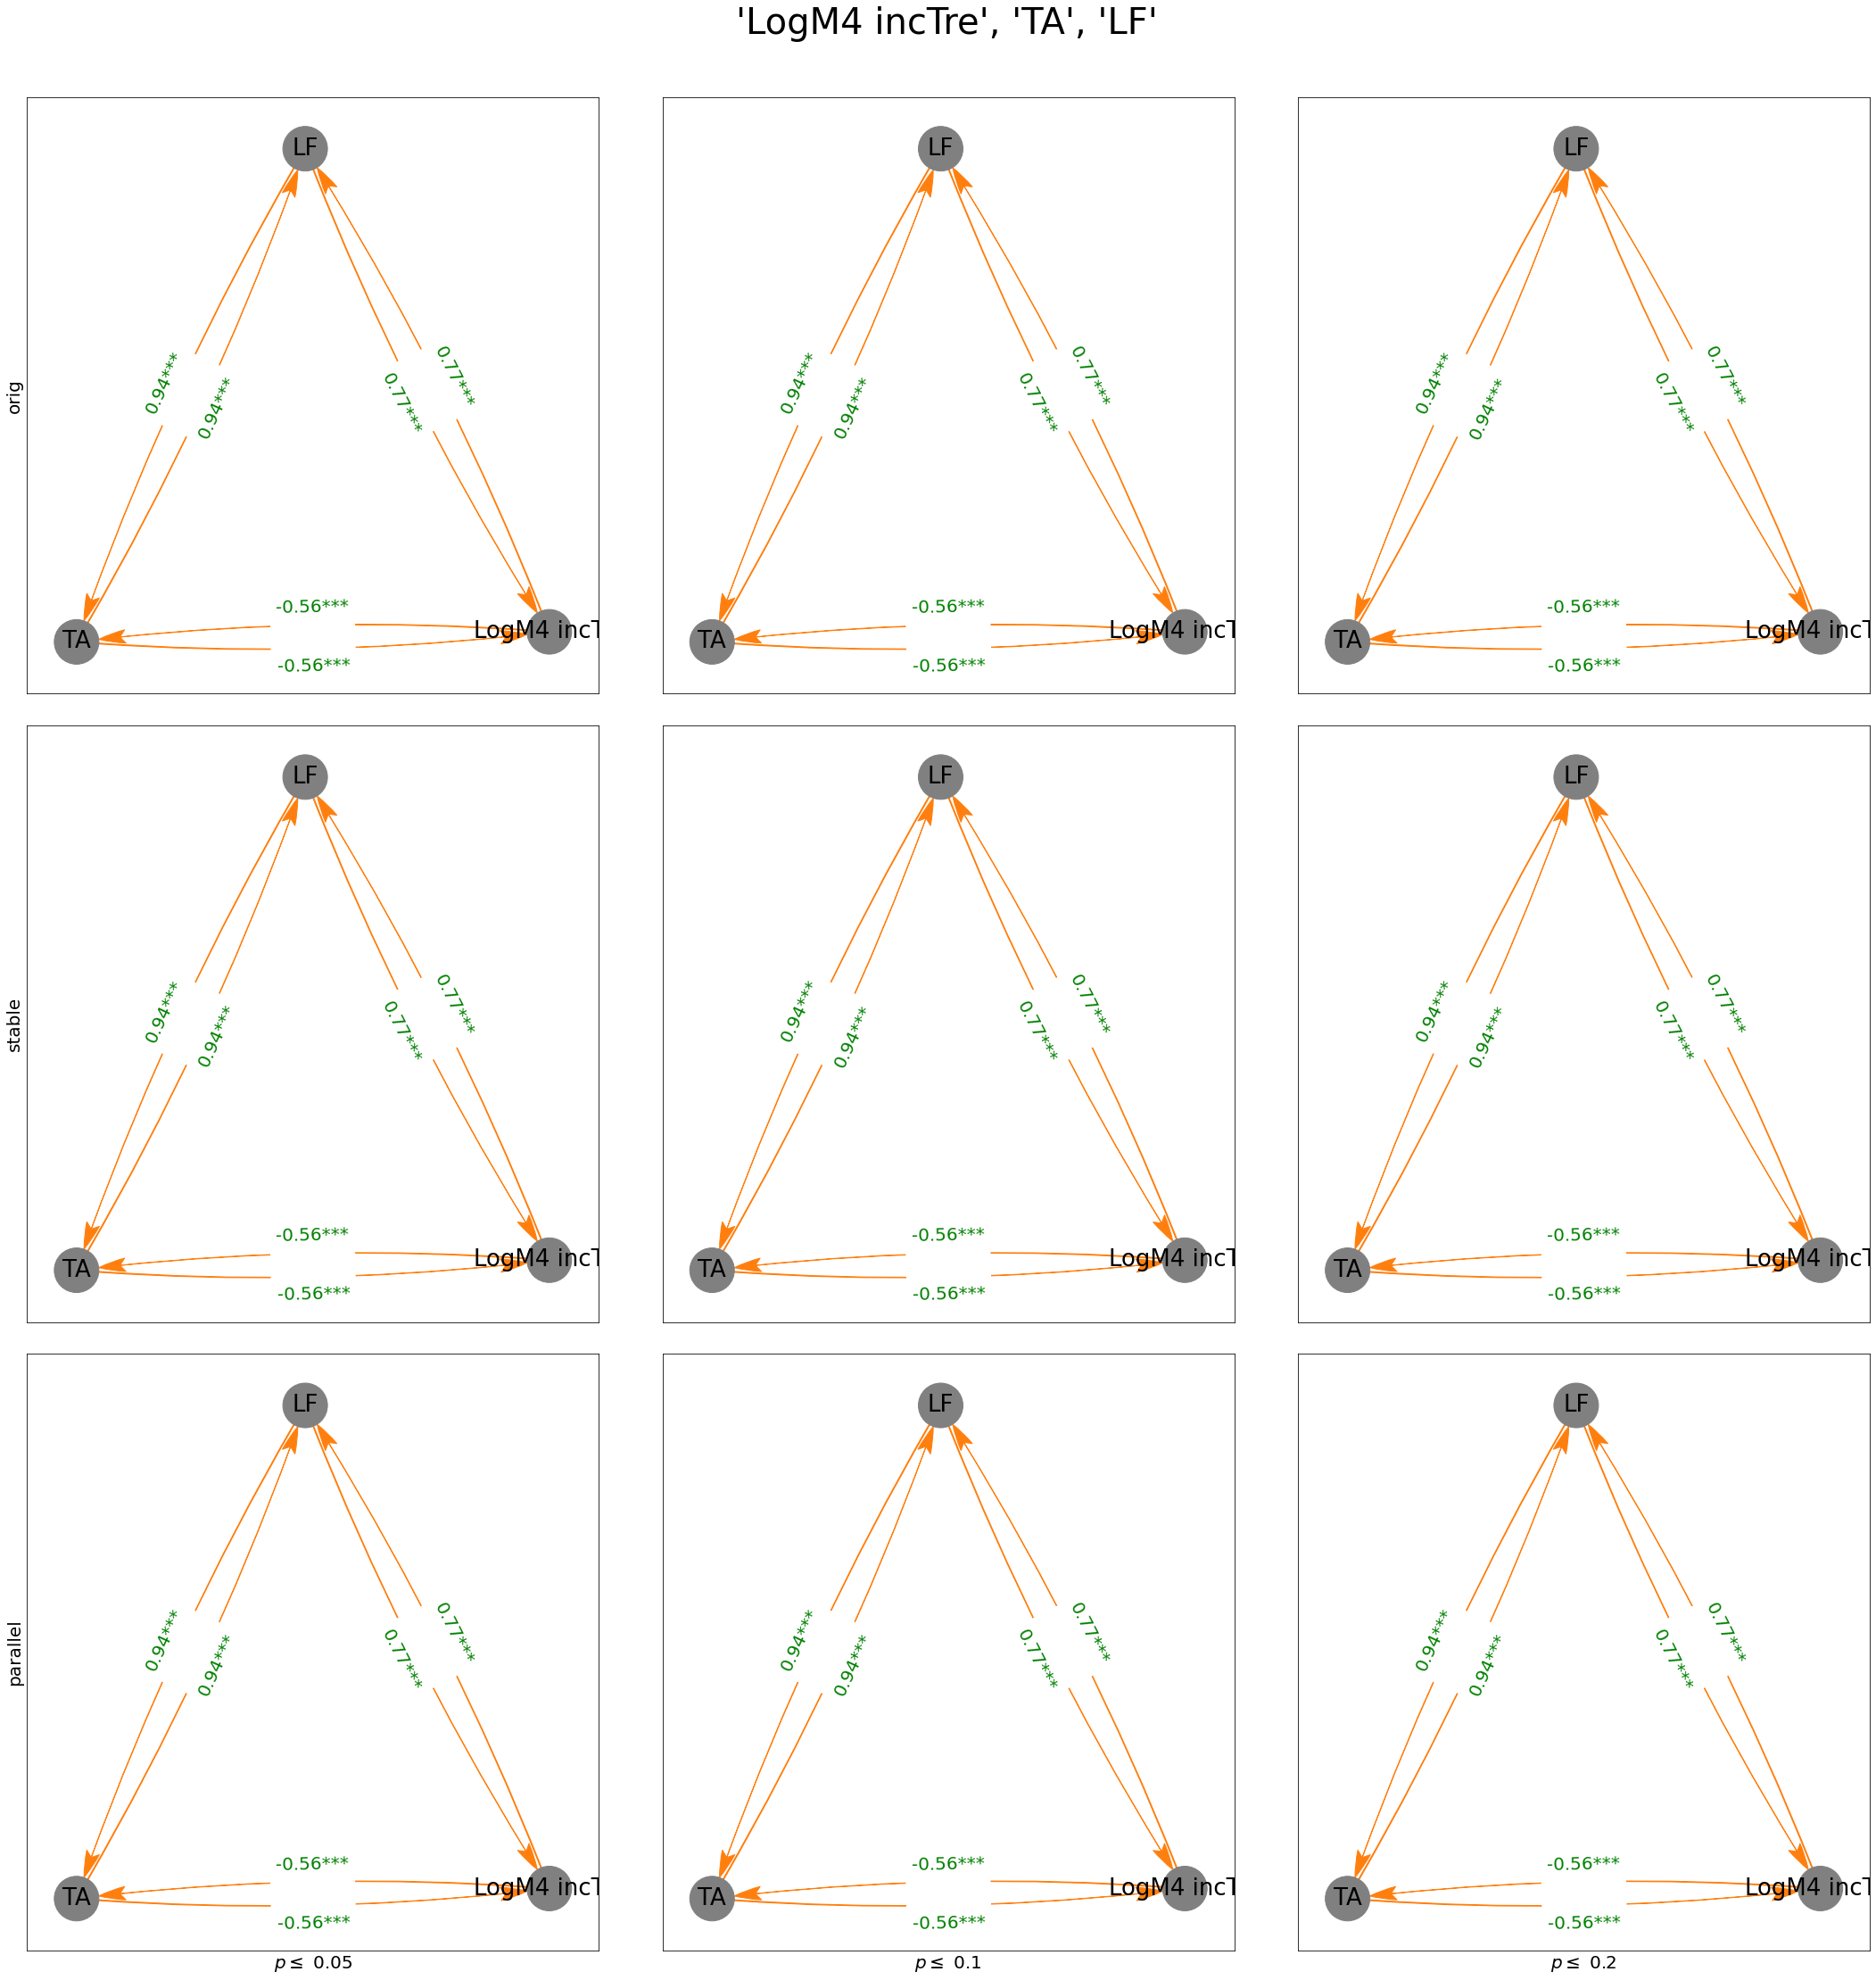

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

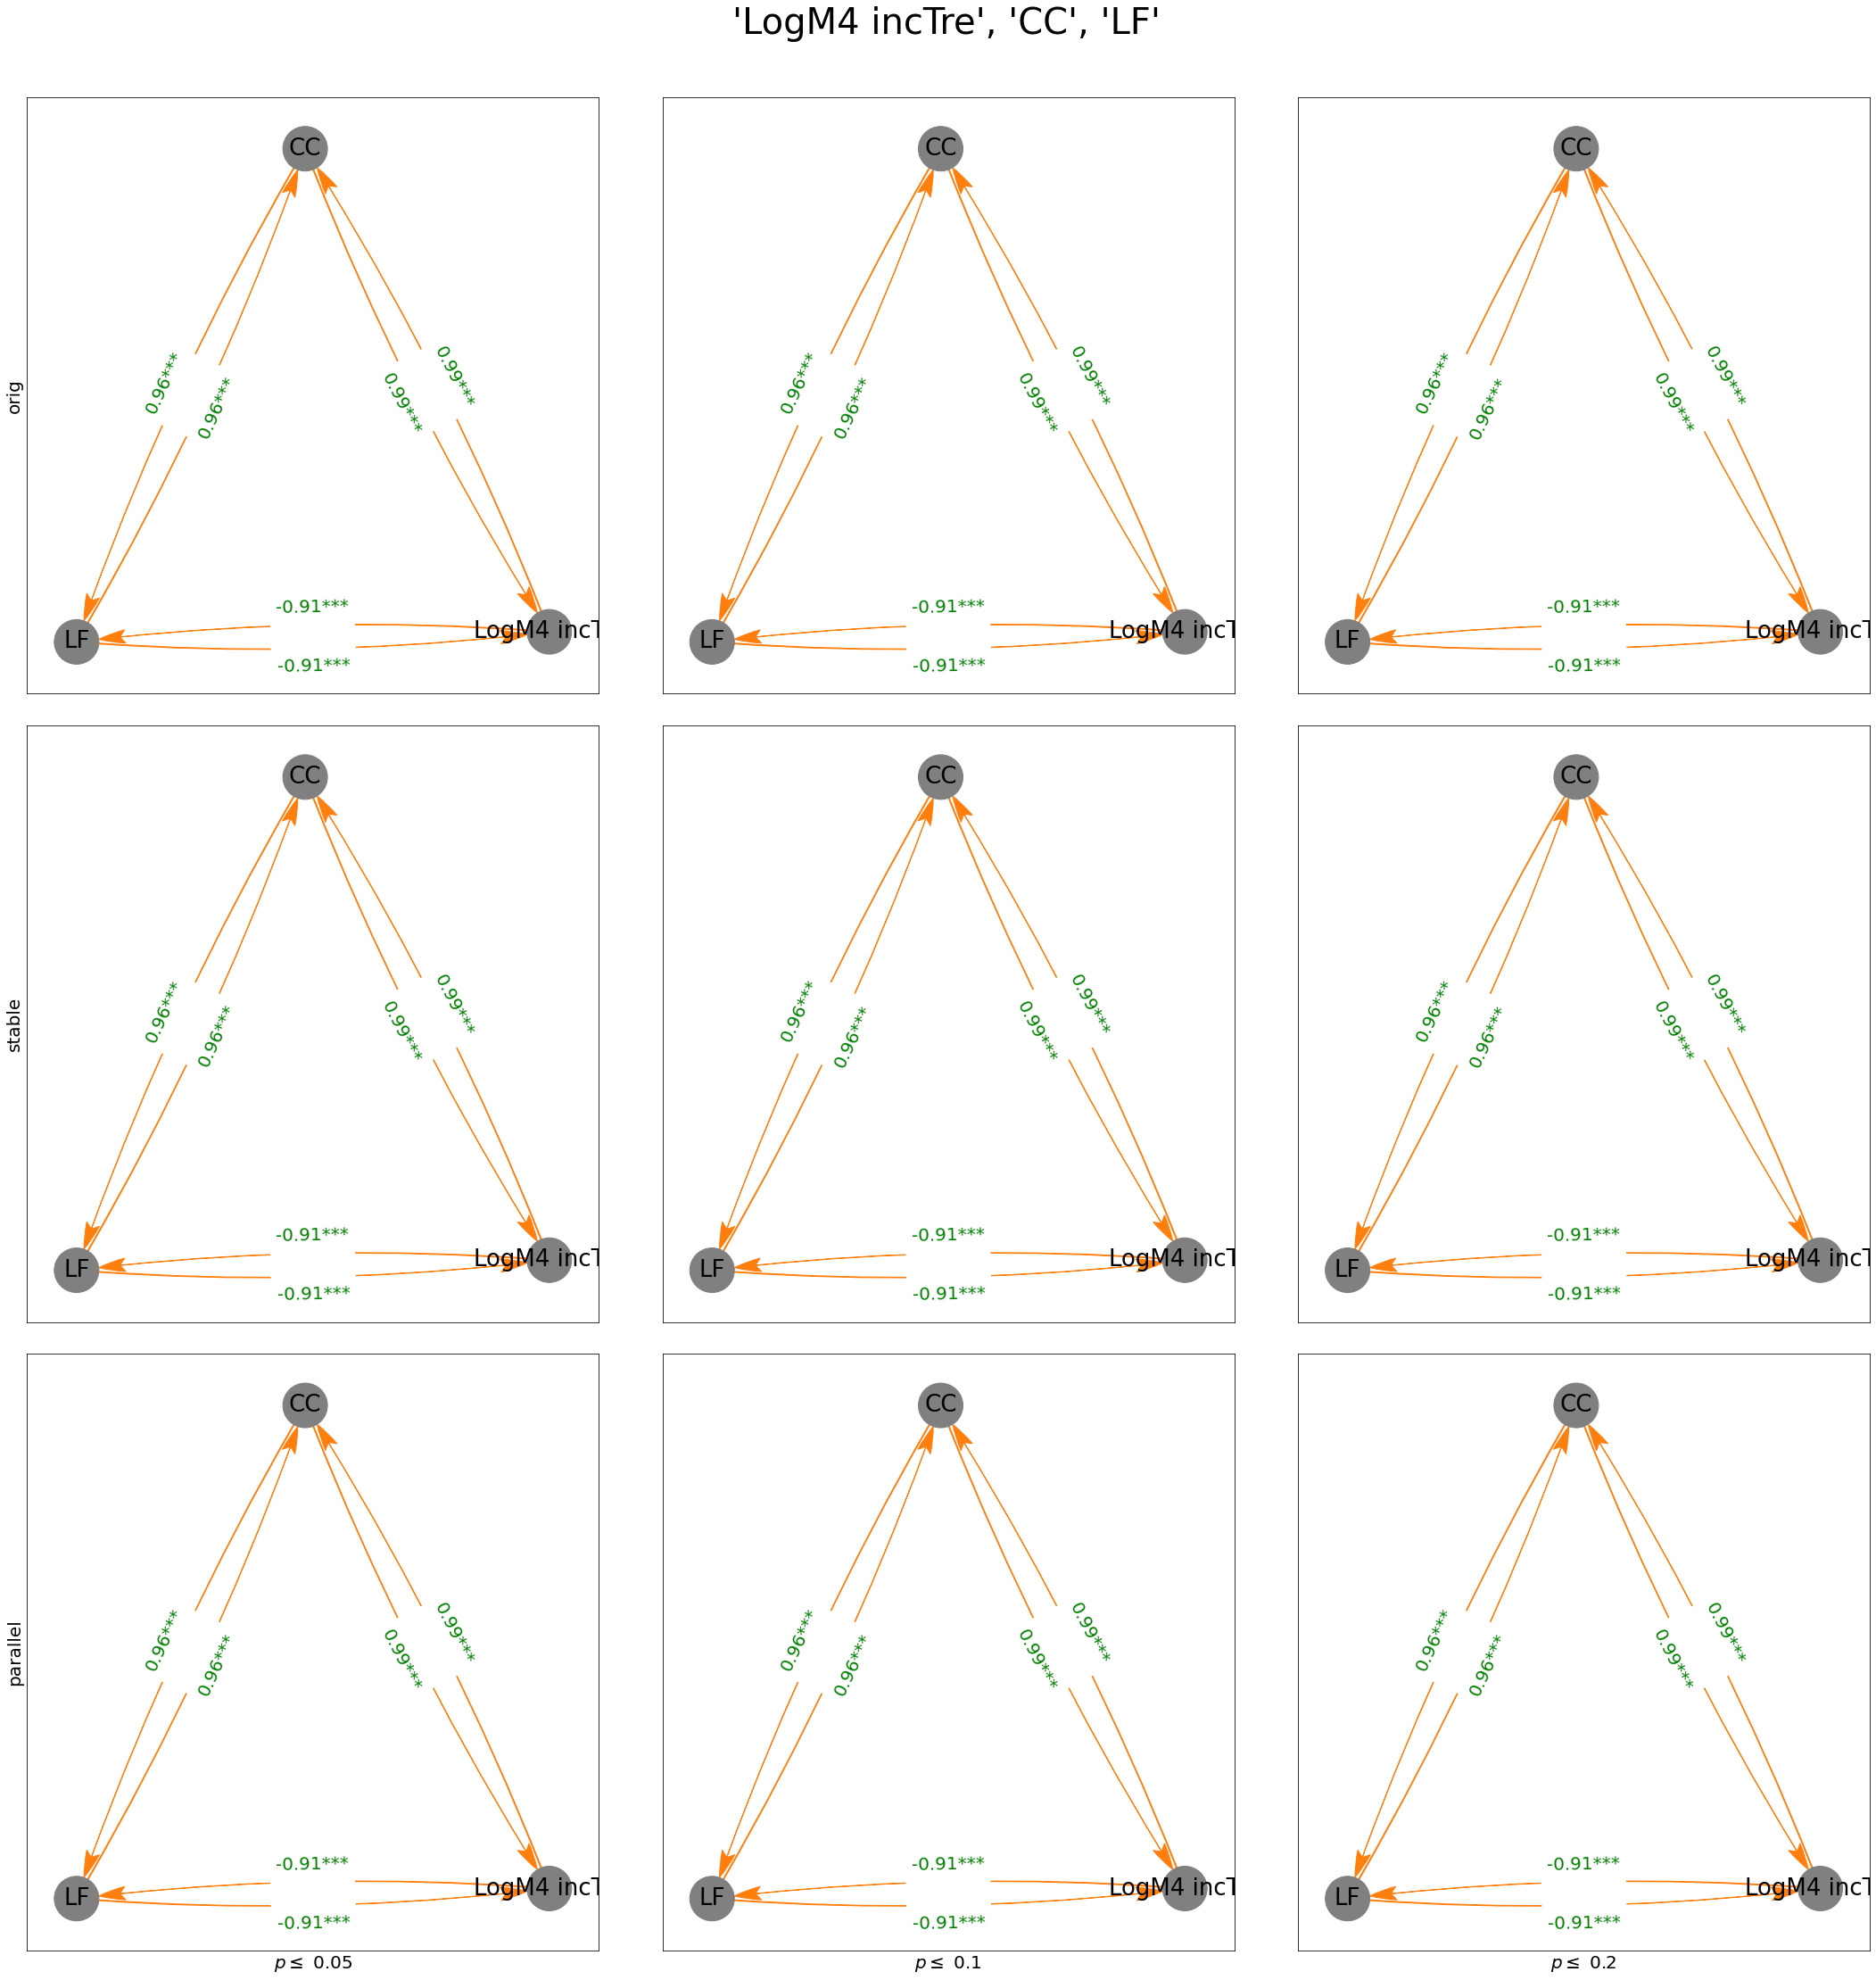

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

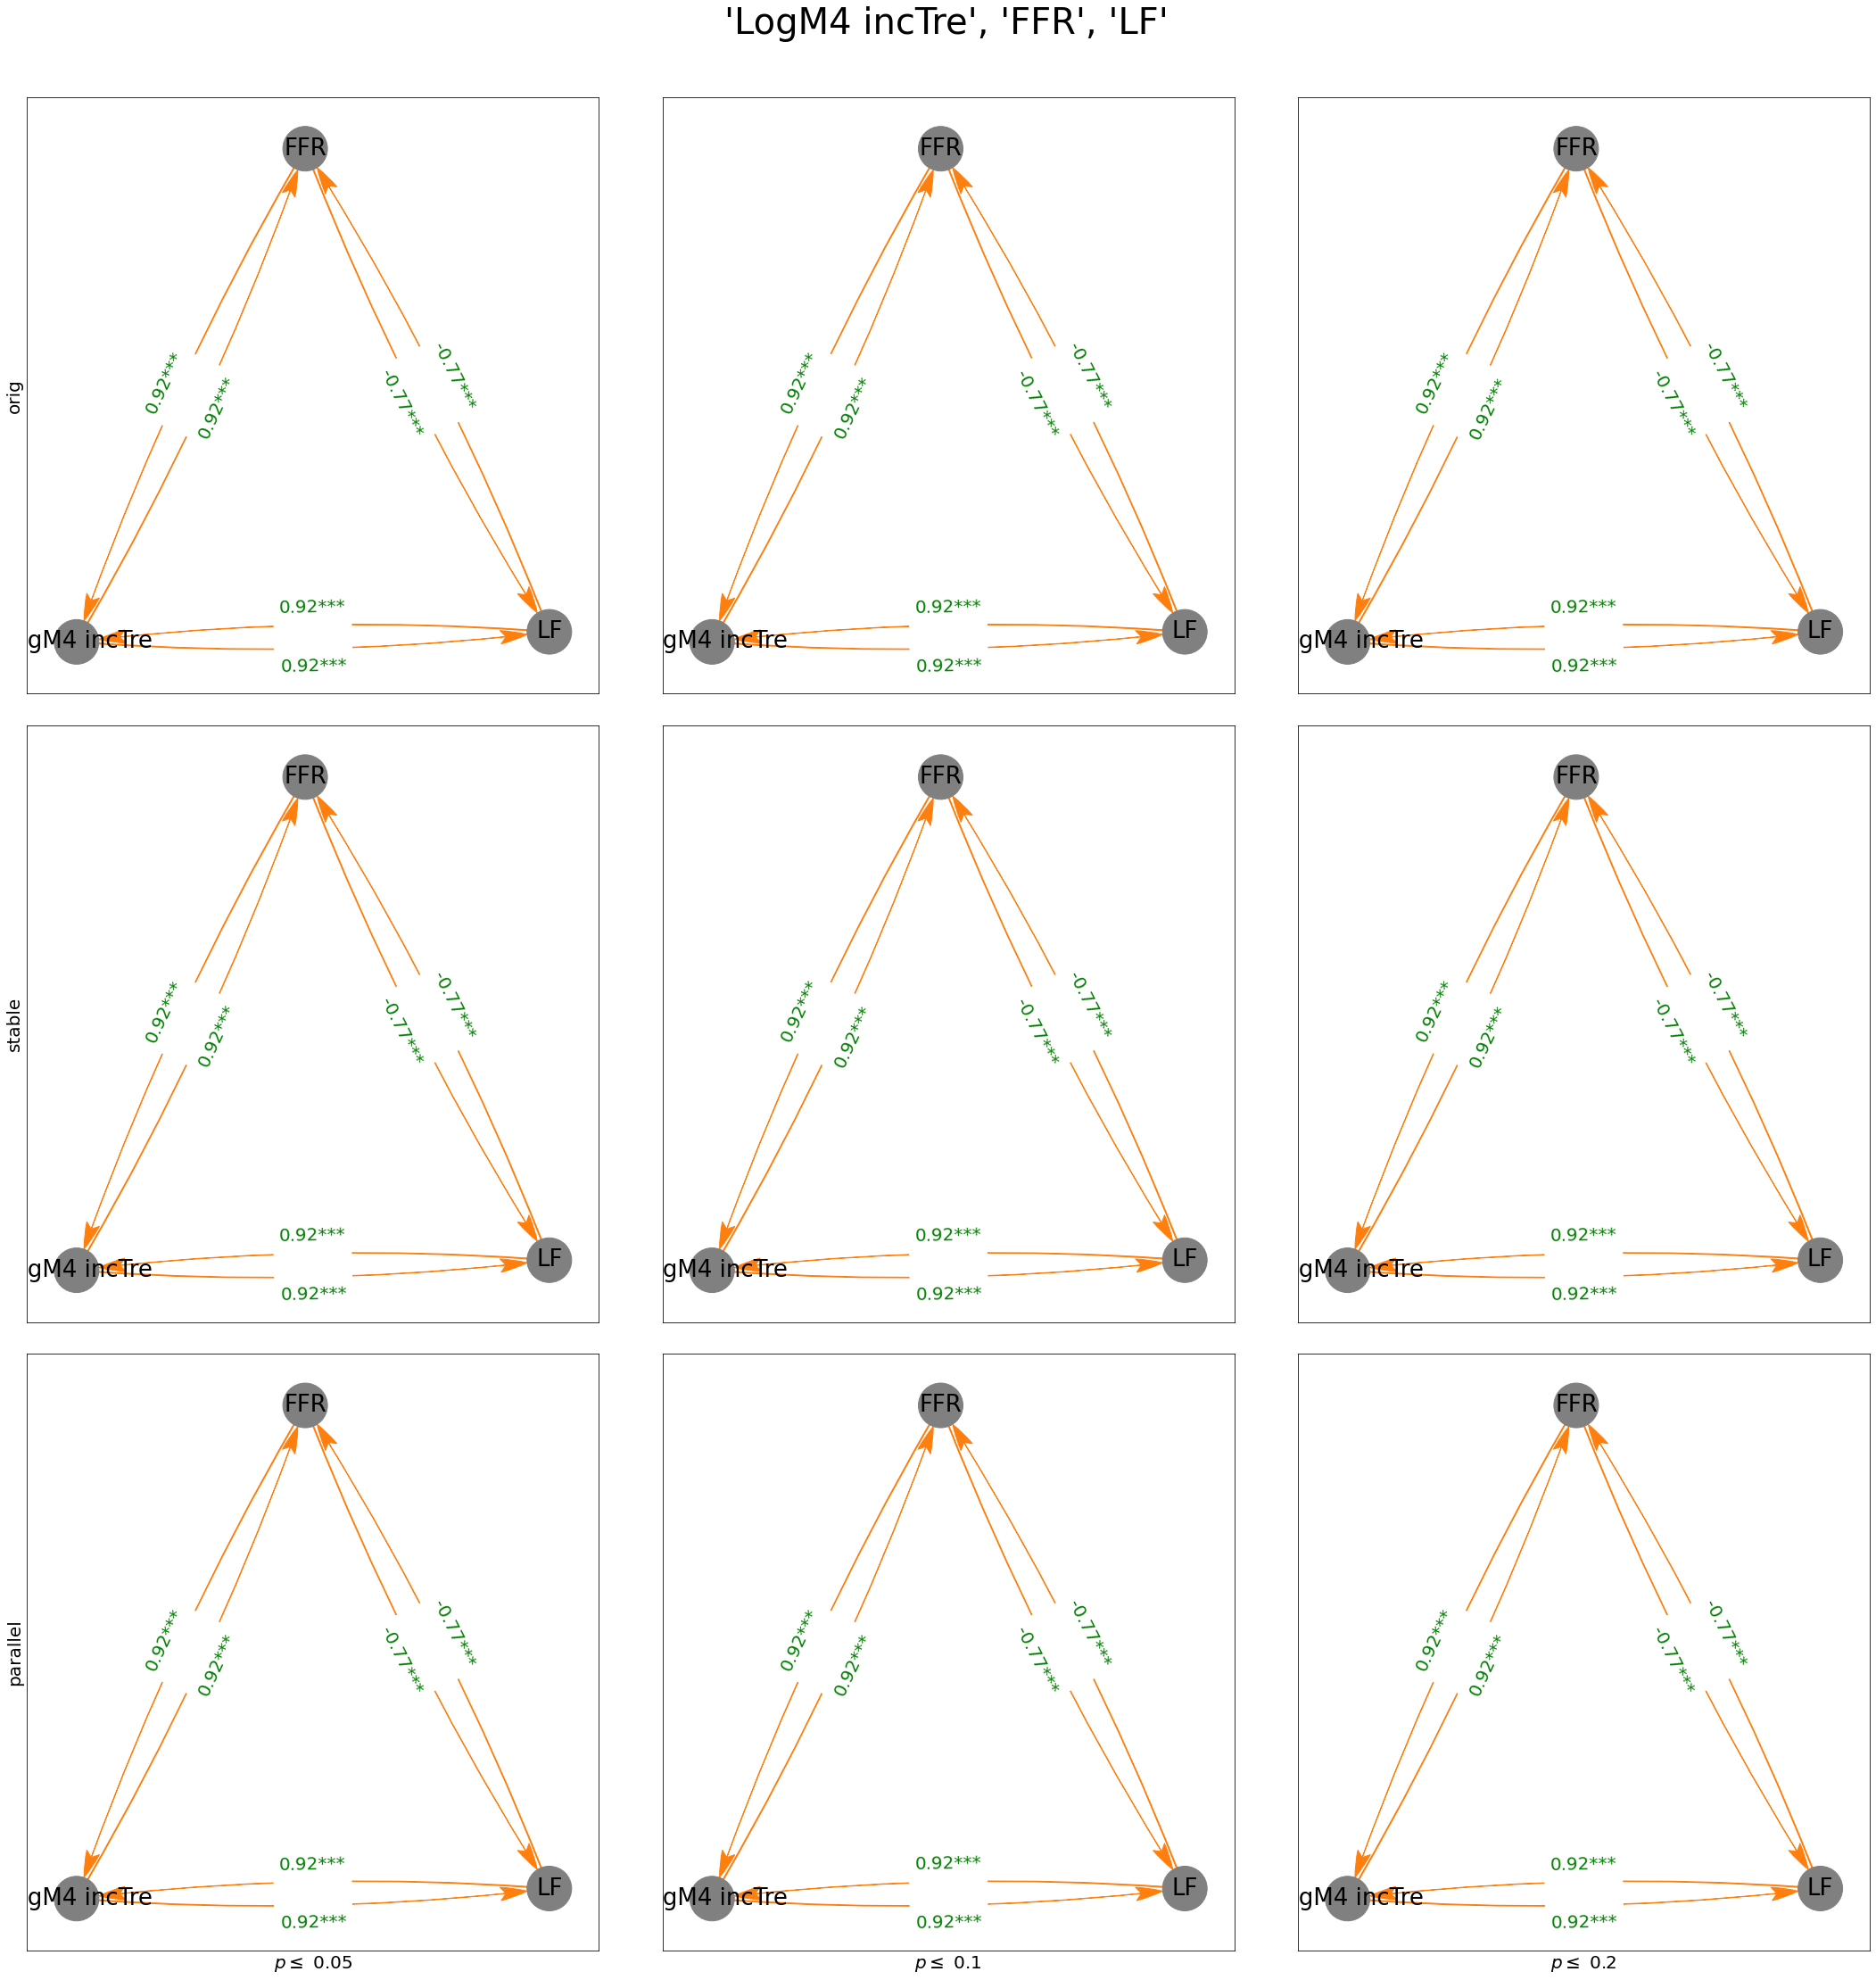

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

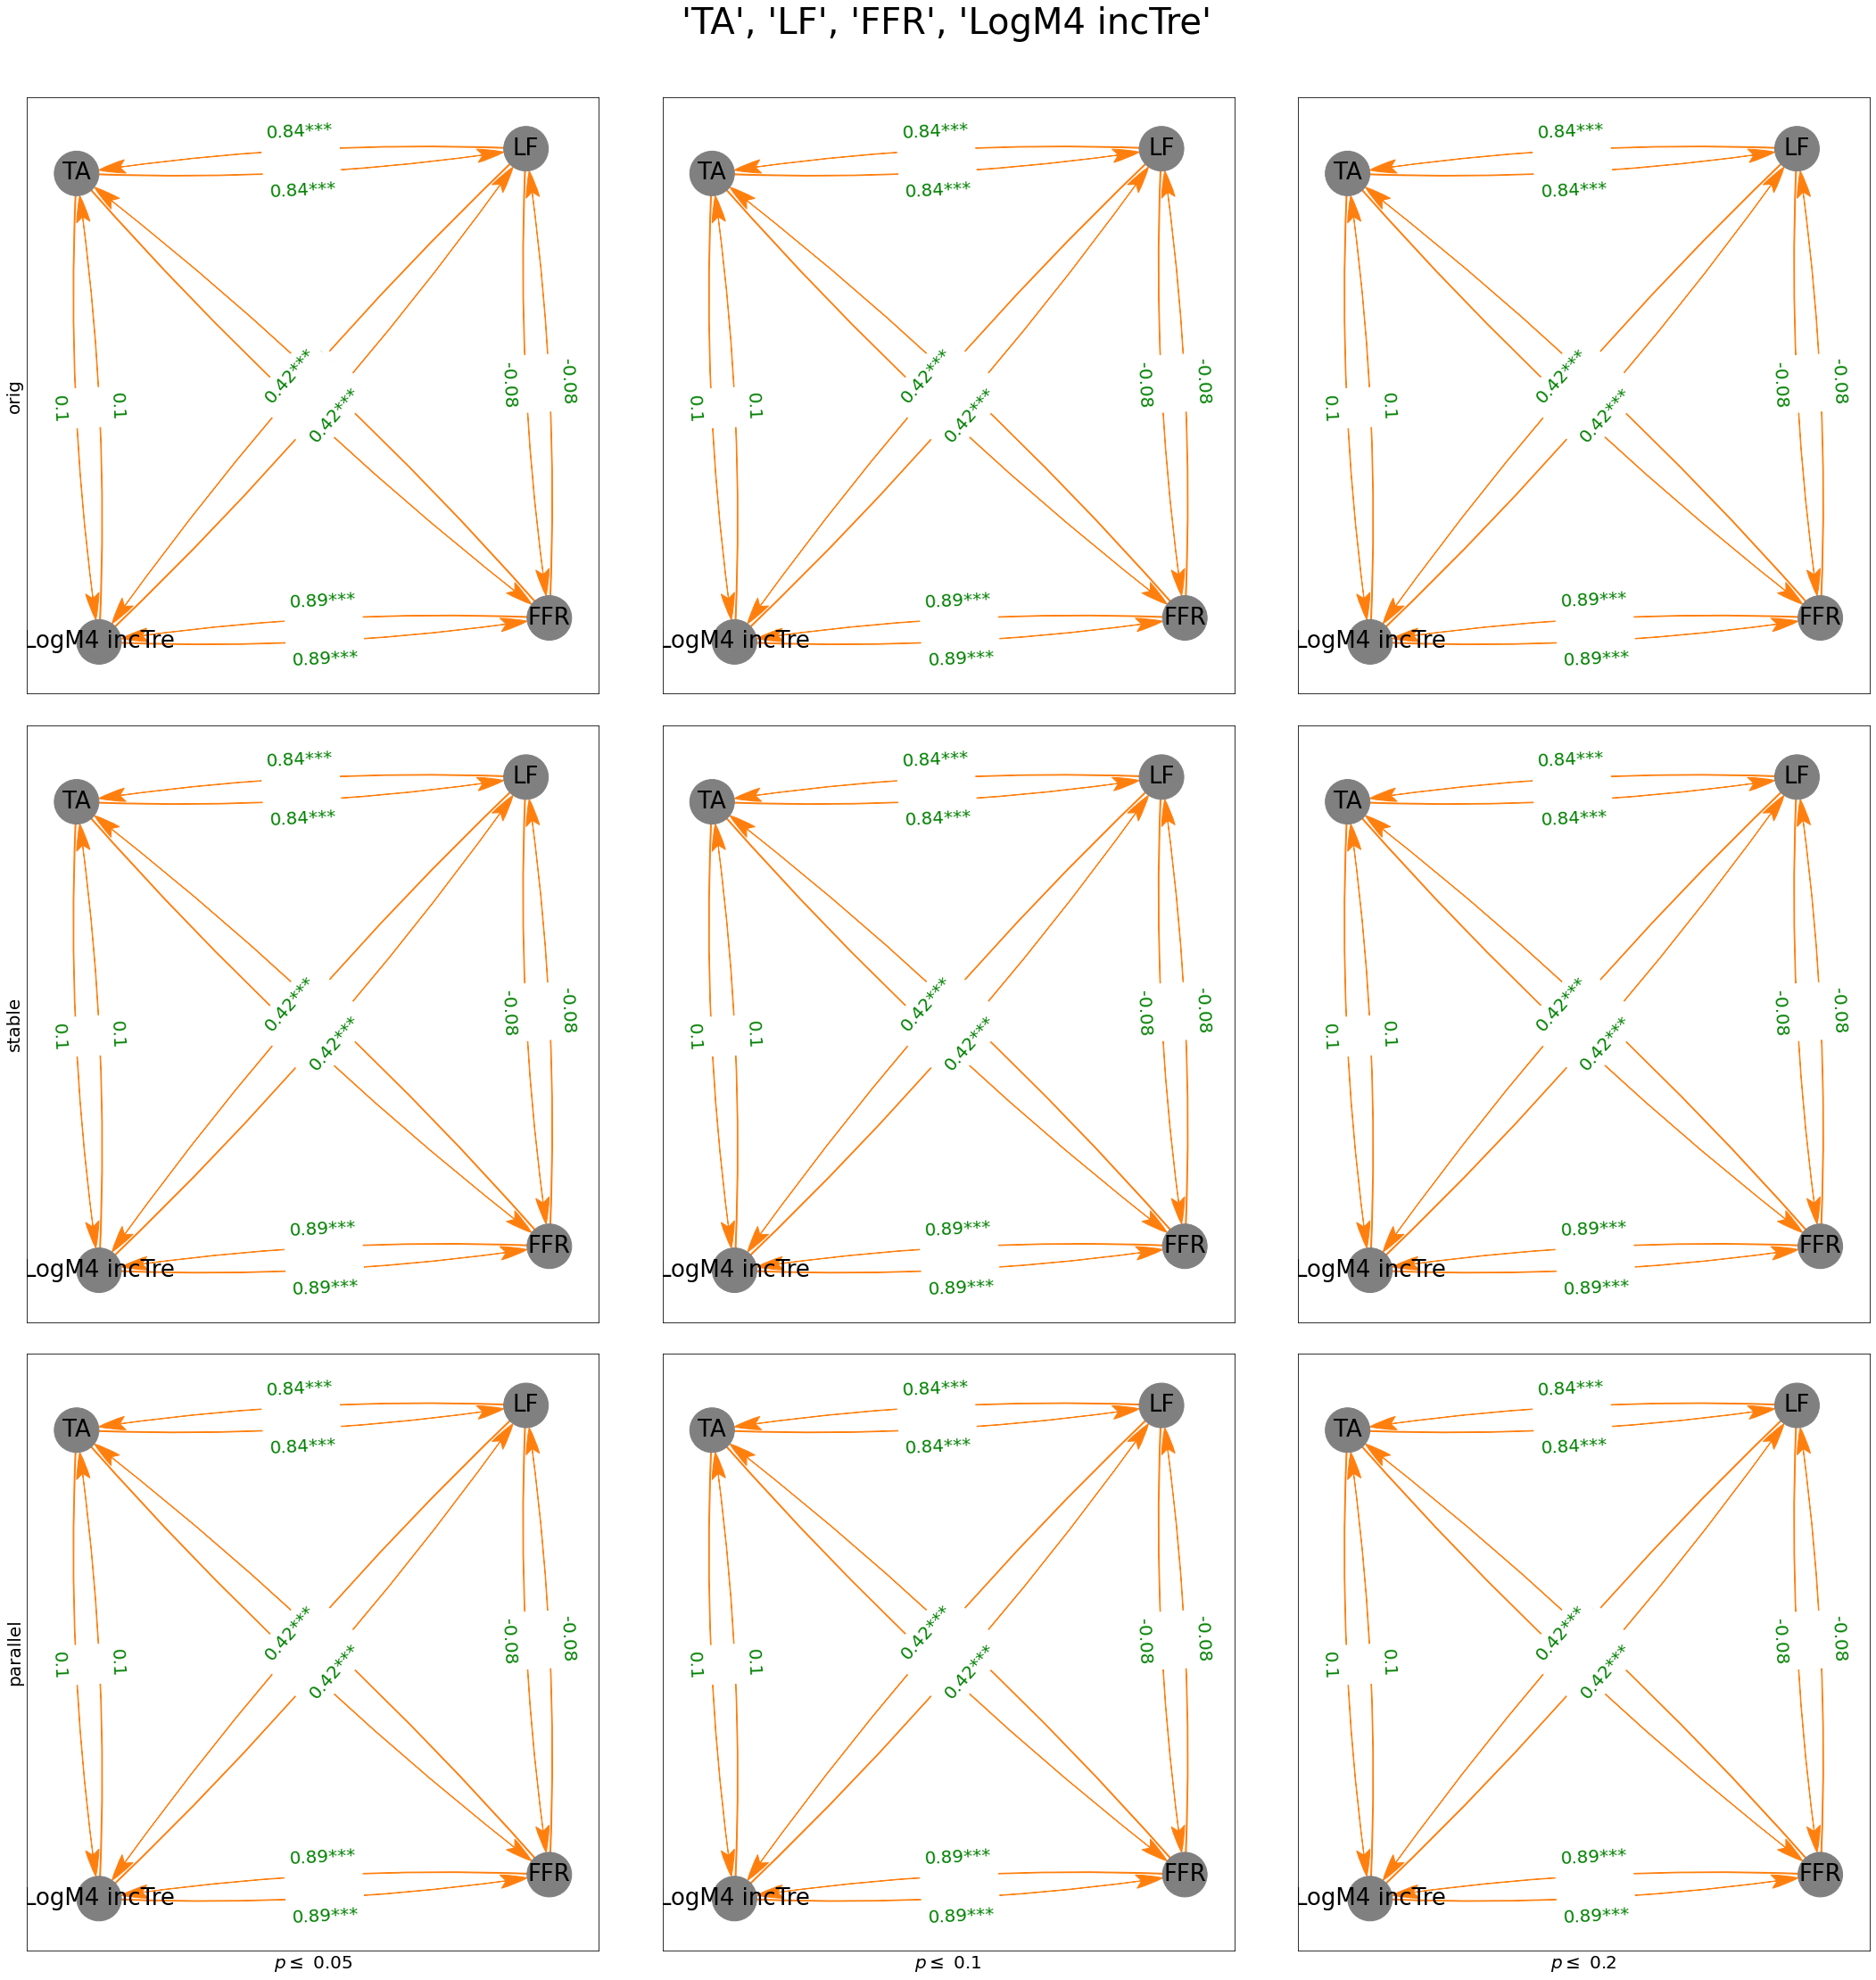

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

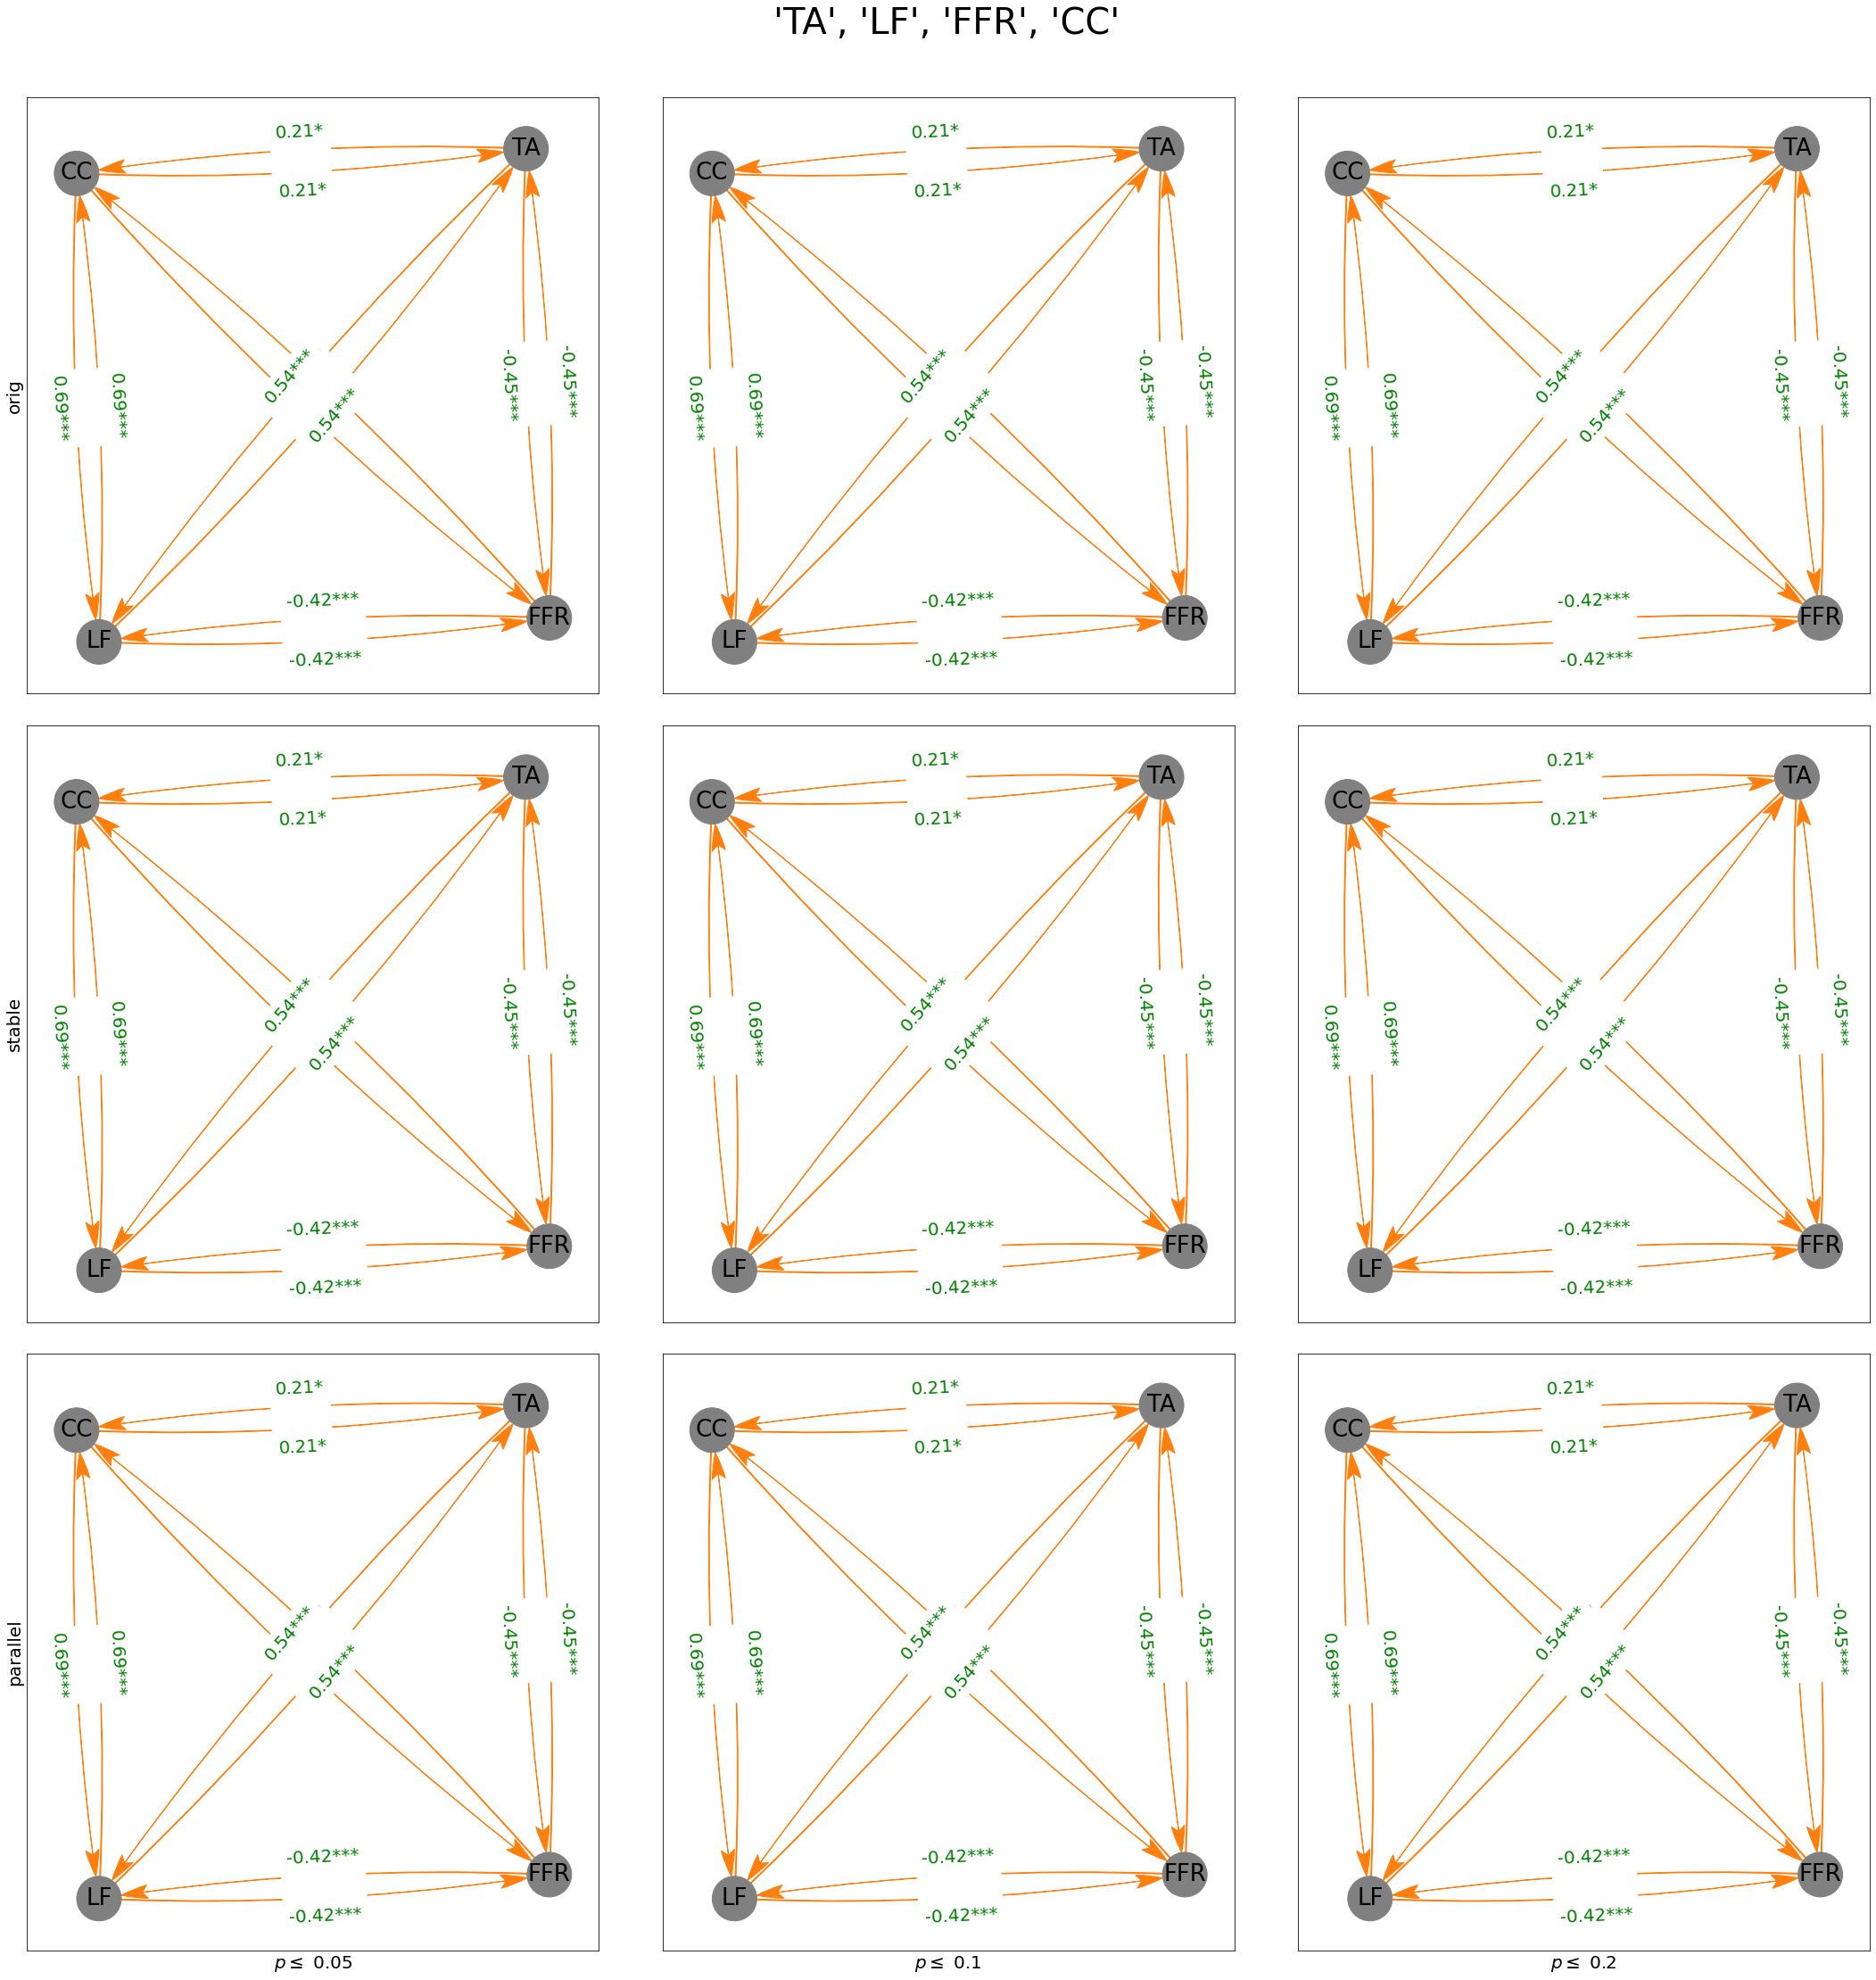

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

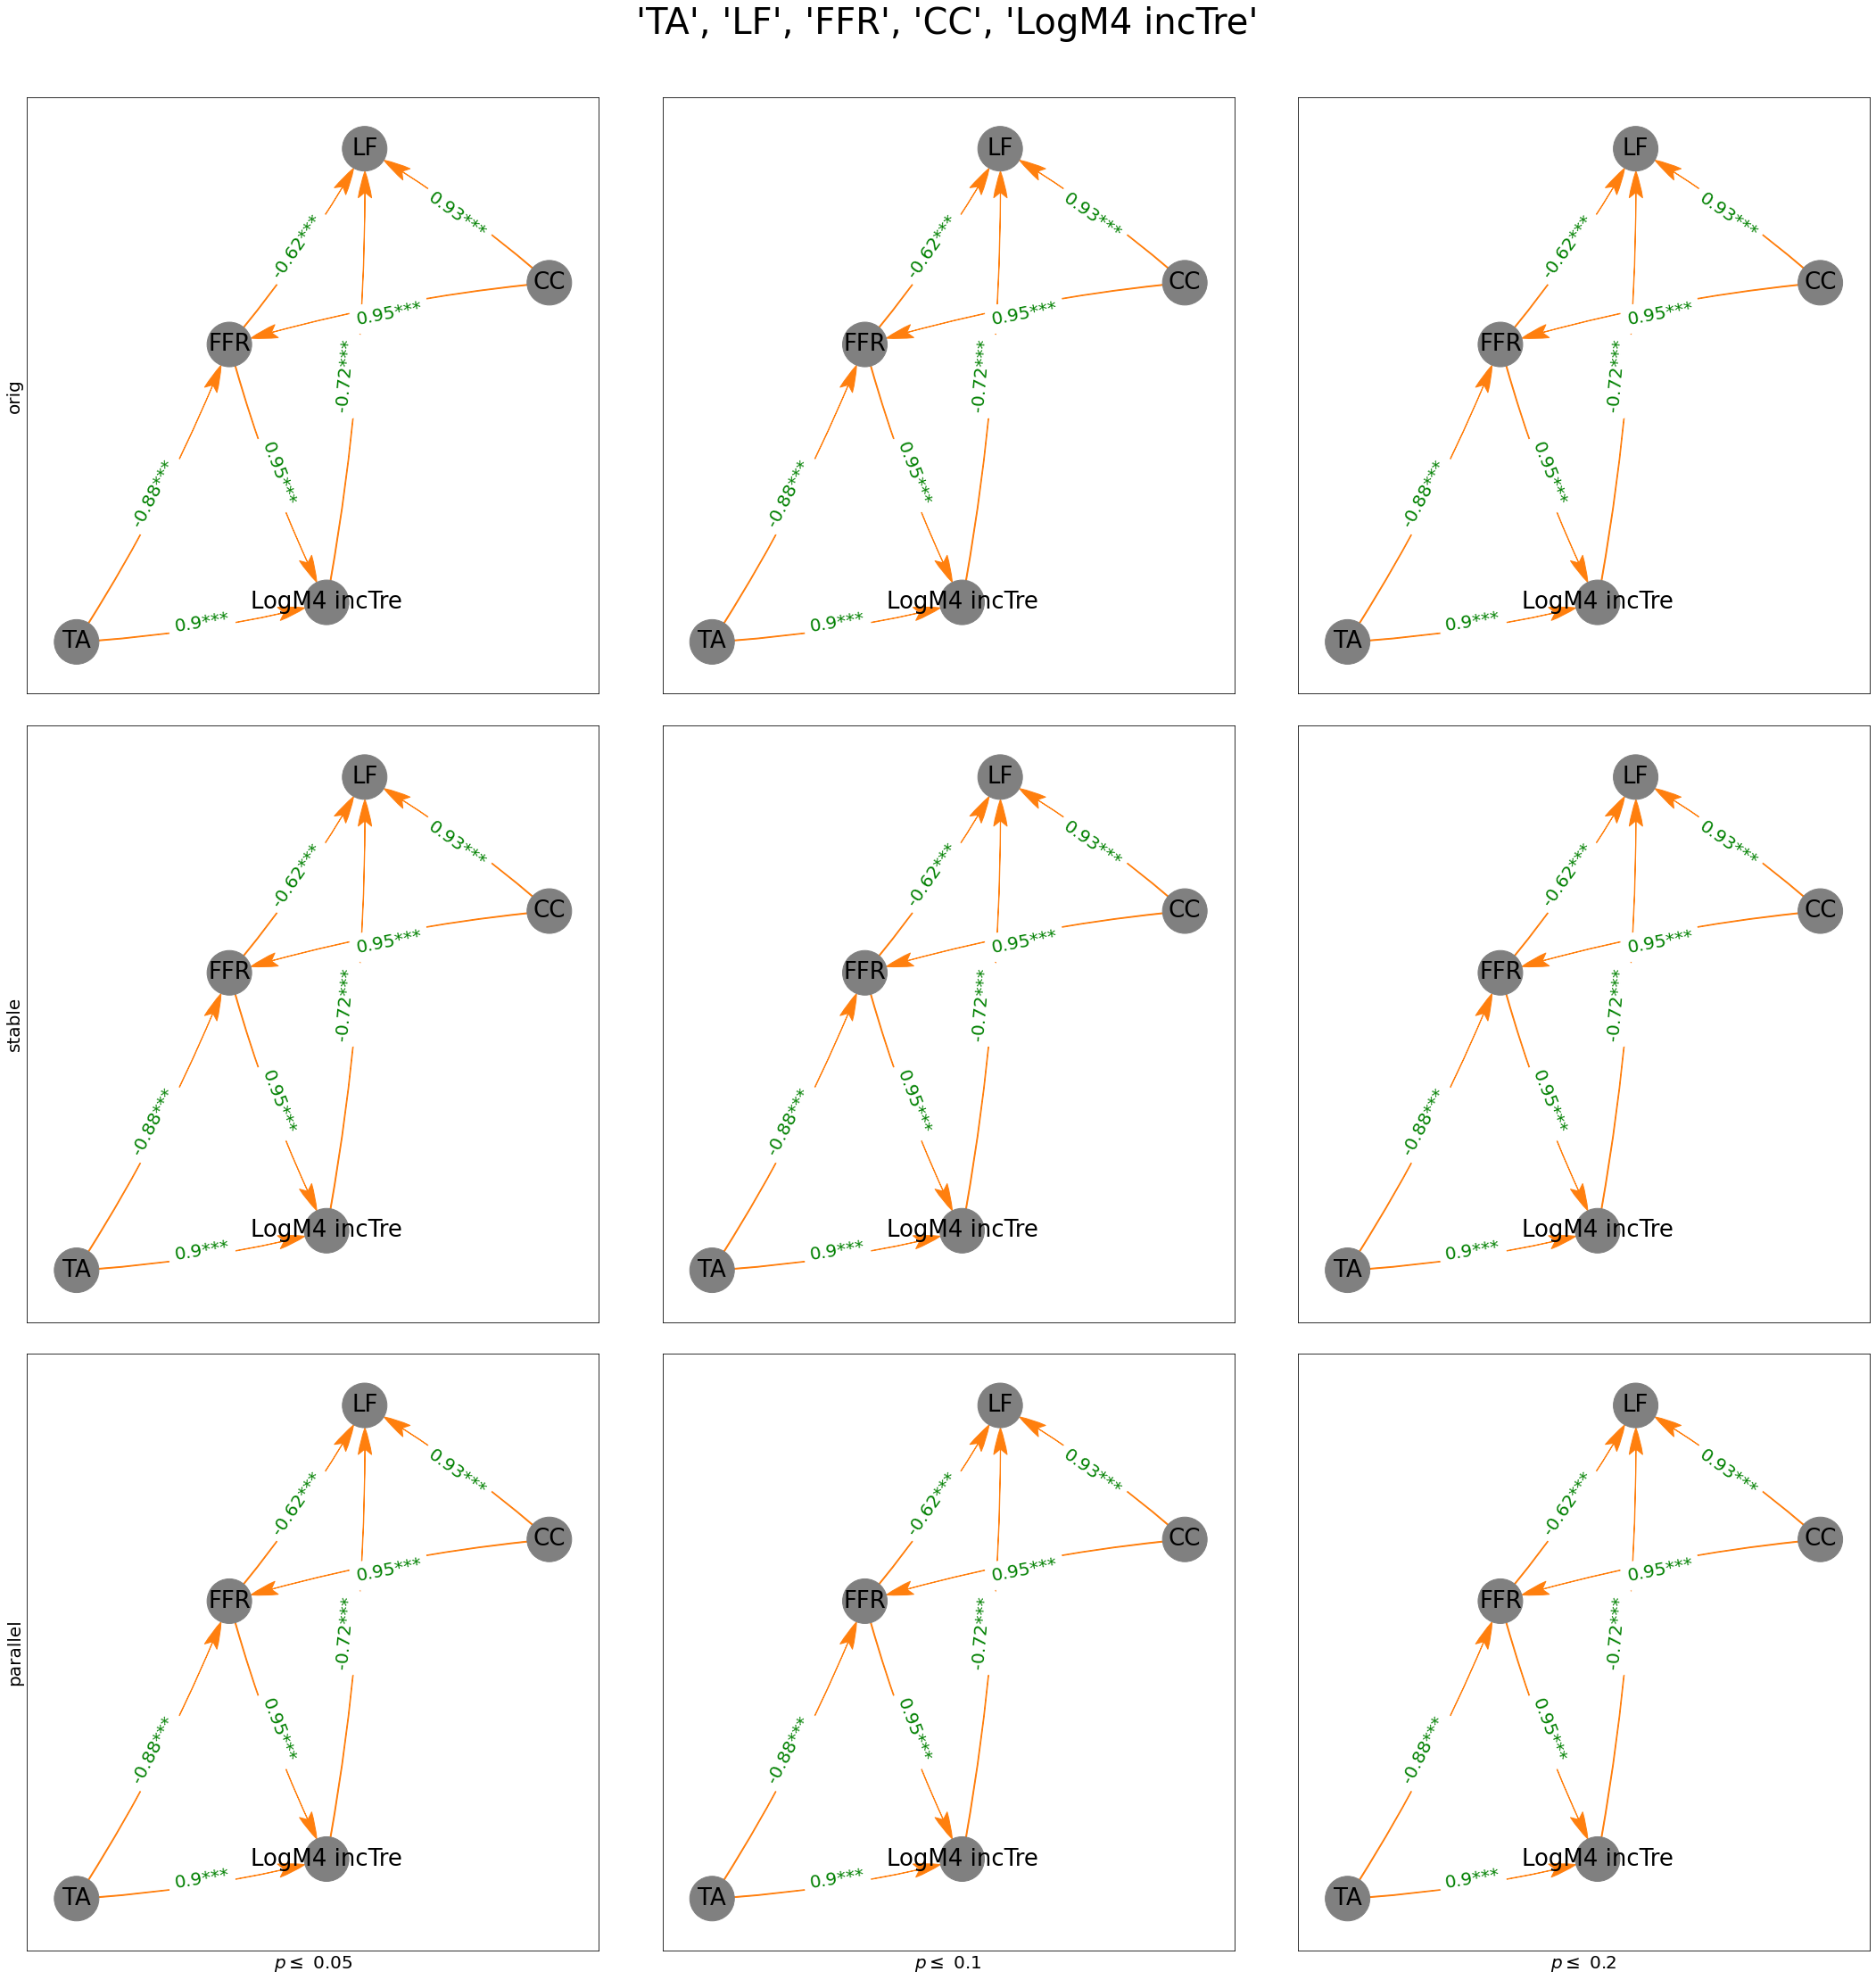

OutEdgeView([('TA', 'FFR'), ('TA', 'LogM4 incTre'), ('FFR', 'LF'), ('FFR', 'LogM4 incTre'), ('LogM4 incTre', 'LF'), ('CC', 'LF'), ('CC', 'FFR')])

In [33]:
def graph_DAG(edges, data_reg, title = "", 
              fig = False, ax = False, 
              edge_labels = False,sig_vals = [0.05, 0.01, 0.001]):
    pcorr = data_reg.pcorr()
    graph = nx.DiGraph()
    def build_edge_labels(edges, df, sig_vals):
        edge_labels = {}
        for edge in edges:
            controls = [key for key in df.keys() if key not in edge]
            controls = list(set(controls))
            keep_controls = []
            for control in controls:
                control_edges = [ctrl_edge for ctrl_edge in edges if control == ctrl_edge[0] ]
                if (control, edge[1]) in control_edges:
                    keep_controls.append(control)                
#             print(edge, keep_controls)
            pcorr = df.partial_corr(x = edge[0], y = edge[1], covar=keep_controls,
                                  method = "pearson")
            label = str(round(pcorr["r"][0],2))
            pvalue = pcorr["p-val"][0]
#             pcorr = df[[edge[0], edge[1]]+keep_controls].pcorr()
#             label = pcorr[edge[0]].loc[edge[1]]

            for sig_val in sig_vals:
                if pvalue < sig_val: 
                    label = label + "*"   
            
            edge_labels[edge] = label
        return edge_labels
    
    if edge_labels == False:
        edge_labels = build_edge_labels(edges, 
                                        data_reg, 
                                        sig_vals=sig_vals) 
    graph.add_edges_from(edges)
    color_map = ["grey" for g in graph]

    if fig == False and ax == False: fig, ax = plt.subplots(figsize = (20,12))
    graph.nodes()
    plt.tight_layout()
    #pos = nx.spring_layout(graph)
    pos = graphviz_layout(graph)

    edge_labels2 = []
    for u, v, d in graph.edges(data=True):
        if pos[u][0] > pos[v][0]:  
            if (v,u) in edge_labels.keys():
                edge_labels2.append(((u, v,), f'{edge_labels[u,v]}\n\n\n{edge_labels[(v,u)]}'))  
        if (v,u) not in edge_labels.keys():
            edge_labels2.append(((u,v,), f'{edge_labels[(u,v)]}'))
    edge_labels = dict(edge_labels2)

    nx.draw_networkx(graph, pos, node_color=color_map, node_size = 2500,
                     with_labels=True,  arrows=True,
                     font_color = "black",
                     font_size = 26, alpha = 1,
                     width = 1, edge_color = "C1",
                     arrowstyle=ArrowStyle("Fancy, head_length=3, head_width=1.5, tail_width=.1"),
                     connectionstyle='arc3, rad = 0.05',
                     ax = a)
    nx.draw_networkx_edge_labels(graph,pos,
                                 edge_labels=edge_labels,
                                 font_color='green',
                                 font_size=20,
                                ax = a)
    

DAG_models_vars = {0:["Log M4 including Treasuries", "TA", "LF"],
                  1:["Log M4 including Treasuries", "CC", "LF"],
                  2:["Log M4 including Treasuries", "FFR", "LF"],
                  3:["TA", "LF", "FFR", "Log M4 including Treasuries"],
                  4:["TA", "LF", "FFR", "CC"],
                  5:["TA", "LF", "FFR", "CC","Log M4 including Treasuries"],}
# link_sigs = [0.05, 0.1, 0.2]
link_sigs = [0.05, .1, .2]
algorithms = ["orig", "stable", "parallel"]
for keys in DAG_models_vars.values():
    fig, ax = plt.subplots(len(algorithms), len(link_sigs), figsize = (30,30))
    max_cond_vars = len(keys) - 2
    data_reg = data[keys].dropna()
    data_reg.rename(columns = {col:firstLetterWord(col) for col in keys}, inplace = True)
    keys = data_reg.keys()
    c = PC(data_reg[keys].dropna())
    max_cond_vars = len(keys) - 2
    i,j = 0,0
    for sig in link_sigs:
        for algorithm in algorithms:
            model = c.estimate(return_type = "pdag", variant = algorithm, 
                               significance_level = sig, 
                               max_cond_vars = max_cond_vars, ci_test = "pearsonr")
            edges = model.edges()
            pcorr = data_reg.pcorr()
            weights = {}
            a = ax[i][j]
            graph_DAG(edges, data_reg, fig = fig, ax = a)
        
            if j == 0:
                a.set_ylabel(algorithm, fontsize = 20)
            if i == len(algorithms) - 1:
                a.set_xlabel("$p \leq$ "+ str(sig), fontsize = 20)
            i += 1
        j += 1
        i = 0
    plt.suptitle(str(list(keys)).replace("[","").replace("]",""), fontsize = 40, y =1.035)
    plt.show()
    plt.close()
edges